In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"
np.random.seed(12001)


# Define the model that generates pair simulations.
yuima = importr("yuima")
n_jumpou_NIG_sim_string = """
n_jumpou_NIG = function(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  jumpcoef = matrix(c("j11", "j12", "j21", "j22"), 2, 2, byrow=TRUE) 
  
  alpha = alpha
  beta = c(beta1, beta2)
  delta0 = delta0
  mu = c(mu1, mu2)
  Lambda = matrix(c(lambda11, lambda12, lambda21, lambda22), 2, 2, byrow=TRUE)
  
  ou_model = setModel(drift=drift, diffusion=diffusion, jump.coeff=jumpcoef, 
                      measure.type="code",
                      measure=list(df="rNIG(z, alpha, beta, delta0, mu, Lambda)"), 
                      time.variable = "t",
                      state.var=c("X1","X2"), solve.variable=c("X1","X2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    jumpou_sim = simulate(ou_model, 
                          true.par=list(
                            mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                            sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                            j11=j11, j12=j12, j21=j21, j22=j22,
                            alpha=alpha, beta=beta, delta0=delta0, mu=mu, Lambda=Lambda), 
                          xinit=xinit_vec[[i]], sampling=newsamp)
    original_data = jumpou_sim@data@original.data
    one_sim_jumpou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_jumpou) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_jumpou
  }
  return(n_sim_data)
}
"""

n_jumpou_NIG_sim = SignatureTranslatedAnonymousPackage(n_jumpou_NIG_sim_string, "n_jumpou_NIG_sim")
def n_jumpou_simulation(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_jumpou_NIG_sim.n_jumpou_NIG(random_seed, num_sim,
                                      mu11, mu12, mu21, mu22, 
                                      sigma11, sigma12, sigma21, sigma22,
                                      j11, j12, j21, j22,
                                      alpha, beta1, beta2, delta0, mu1, mu2, 
                                      lambda11, lambda12, lambda21, lambda22,
                                      xinit_vec, T0, T, length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef




def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    
    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series2.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values #8(8)
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2])#7(34)
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2']
    
    return stats_data





def loss_function(params):

    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_jumpou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=params[12], 
        beta1=beta1, beta2=beta2, 
        delta0=params[13], 
        mu1=params[14], mu2=params[15], 
        lambda11=params[16], lambda12=lambda12, 
        lambda21=lambda21, lambda22=1/params[16],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)

    moment_loss = np.abs(n_real_stats - n_sim_stats)
    sum_loss = np.sum(moment_loss)
    
    sum_loss[0] = sum_loss[0]*50
    sum_loss[1] = sum_loss[1]*50    
    sum_loss[2] = sum_loss[2]*50
    sum_loss[3] = sum_loss[3]*50
    sum_loss[4] = sum_loss[4]*10
    sum_loss[5] = sum_loss[5]*10
    
    loss = np.sum(sum_loss)

    print(sum_loss)
    print(loss)
    print('----------')

    return loss



real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_calibration.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_calibration.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]
n_real_stats = real_stats


#alpha
beta1 = 0
beta2 = 0
#delta0
#mu1
#mu2
#lambda11 = 1
lambda12 = 0
lambda21 = 0
#lambda22 = 1


initial0 = [1, 1, 1, 1,
            -1, -1, -1, -1,
            0.1, 0.1, 0.1, 0.1,
            1, 1,
            1, 1,
            1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(0, None), (None, None), (0, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (0, None), (0, None),
                       (None, None), (None, None), 
                       (0, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1]  1.0  1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1  0.1  1.0  1.0  1.0
[16]  1.0  1.0

return_mean1        11796.903771
return_mean2        11197.287535
return_sd1          22155.656009
return_sd2          21271.090641
return_skew1         1821.611306
return_skew2         2279.164967
return_kurtosis1     1291.961901
return_kurtosis2     1759.522748
dtype: float64
73573.198876802
----------
 [1]  1.115092  1.000000  1.000000  1.000000 -1.000000 -1.000000 -1.000000
 [8] -1.000000  0.100000  0.100000  0.100000  0.100000  1.000000  1.000000
[15]  1.000000  1.000000  1.000000

return_mean1        11417.610711
return_mean2        11027.580476
return_sd1          22712.545028
return_sd2          21906.404831
return_skew1         2089.702487
return_skew2         2567.869539
return_kurtosis1     1494.499034
return_kurtosis2     1957.953387
dtype: float64
75174.165493532
----------
 [1]  1.793574  1.000000  1.000000  1.000000 -1.000000 -1.000000 -1.000000
 [8] -1.000000  0.100000  0.100

return_mean1         2552.321094
return_mean2        10950.541710
return_sd1          23536.046337
return_sd2          21821.387509
return_skew1         2000.294467
return_skew2         2542.521990
return_kurtosis1     1407.536700
return_kurtosis2     1918.959502
dtype: float64
66729.60930929989
----------
 [1]  7.252909  1.000000  1.000000  1.000000 -1.000000 -1.000000 -1.000000
 [8] -1.000000  0.100000  0.100000  0.100000  0.100000  1.000000  1.000000
[15]  1.000000  1.000000  1.000000

return_mean1         2648.027664
return_mean2        11252.968189
return_sd1          23089.008949
return_sd2          21377.851692
return_skew1         1854.837746
return_skew2         2323.345534
return_kurtosis1     1345.456318
return_kurtosis2     1811.535405
dtype: float64
65703.03149856052
----------
 [1]  7.258636  1.000000  1.000000  1.000000 -1.000000 -1.000000 -1.000000
 [8] -1.000000  0.100000  0.100000  0.100000  0.100000  1.000000  1.000000
[15]  1.000000  1.000000  1.000000

return_mean1

return_mean1         2804.652056
return_mean2        11223.068239
return_sd1          23020.201923
return_sd2          21252.741480
return_skew1         1790.142529
return_skew2         2337.383097
return_kurtosis1     1266.970502
return_kurtosis2     1781.382453
dtype: float64
65476.54227900805
----------
 [1]  7.255931  0.381966  1.000000  1.000000 -1.000000 -1.000000 -1.000000
 [8] -1.000000  0.100000  0.100000  0.100000  0.100000  1.000000  1.000000
[15]  1.000000  1.000000  1.000000

return_mean1         9280.264134
return_mean2        11096.540775
return_sd1          23086.998334
return_sd2          21478.382275
return_skew1         1912.333073
return_skew2         2414.795942
return_kurtosis1     1346.196333
return_kurtosis2     1838.612703
dtype: float64
72454.12356916194
----------
 [1]  7.255931  1.381966  1.000000  1.000000 -1.000000 -1.000000 -1.000000
 [8] -1.000000  0.100000  0.100000  0.100000  0.100000  1.000000  1.000000
[15]  1.000000  1.000000  1.000000

return_mean1

return_mean1         2643.848432
return_mean2        11004.133138
return_sd1          23378.412771
return_sd2          21632.659788
return_skew1         1943.747606
return_skew2         2535.570681
return_kurtosis1     1341.090740
return_kurtosis2     1859.551060
dtype: float64
66339.01421717668
----------
 [1]  7.255931  0.993683  1.000000  1.000000 -1.000000 -1.000000 -1.000000
 [8] -1.000000  0.100000  0.100000  0.100000  0.100000  1.000000  1.000000
[15]  1.000000  1.000000  1.000000

return_mean1         2708.150950
return_mean2        11200.681713
return_sd1          22999.101362
return_sd2          21294.752092
return_skew1         1864.711874
return_skew2         2372.290574
return_kurtosis1     1234.512098
return_kurtosis2     1807.512953
dtype: float64
65481.713615326655
----------
 [1]  7.2559308  0.9936716  1.0000000  1.0000000 -1.0000000 -1.0000000
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000  1.000

return_mean1         2616.871579
return_mean2        10931.887864
return_sd1          23296.597167
return_sd2          21530.138559
return_skew1         1749.094457
return_skew2         2301.996392
return_kurtosis1     1284.517163
return_kurtosis2     1781.020598
dtype: float64
65492.12377939333
----------
 [1]  7.255931  0.993676  1.119669  1.000000 -1.000000 -1.000000 -1.000000
 [8] -1.000000  0.100000  0.100000  0.100000  0.100000  1.000000  1.000000
[15]  1.000000  1.000000  1.000000

return_mean1         2408.212753
return_mean2        10982.578825
return_sd1          22988.638763
return_sd2          21172.763014
return_skew1         1859.201069
return_skew2         2349.094694
return_kurtosis1     1295.768626
return_kurtosis2     1790.687189
dtype: float64
64846.94493443274
----------
 [1]  7.255931  0.993676  1.112261  1.000000 -1.000000 -1.000000 -1.000000
 [8] -1.000000  0.100000  0.100000  0.100000  0.100000  1.000000  1.000000
[15]  1.000000  1.000000  1.000000

return_mean1

return_mean1         2536.795315
return_mean2        10732.369883
return_sd1          23336.612612
return_sd2          21570.822642
return_skew1         1754.633769
return_skew2         2316.039814
return_kurtosis1     1268.465372
return_kurtosis2     1758.302599
dtype: float64
65274.042006116404
----------
 [1]  7.255931  0.993676  1.115091  1.000000 -1.000000 -1.000000 -1.000000
 [8] -1.000000  0.100000  0.100000  0.100000  0.100000  1.000000  1.000000
[15]  1.000000  1.000000  1.000000

return_mean1         2733.850707
return_mean2        10932.088626
return_sd1          23330.571713
return_sd2          21493.356599
return_skew1         1962.958226
return_skew2         2528.012234
return_kurtosis1     1424.973438
return_kurtosis2     1959.140659
dtype: float64
66364.95220226397
----------
 [1]  7.255931  0.993676  1.115093  1.000000 -1.000000 -1.000000 -1.000000
 [8] -1.000000  0.100000  0.100000  0.100000  0.100000  1.000000  1.000000
[15]  1.000000  1.000000  1.000000

return_mean

return_mean1         2690.219270
return_mean2         2316.097894
return_sd1          22990.507239
return_sd2          20993.522201
return_skew1         1788.042229
return_skew2         2266.481485
return_kurtosis1     1277.225824
return_kurtosis2     1726.224084
dtype: float64
56048.3202271597
----------
 [1]  7.255931  0.993676  1.115092  0.167875 -1.000000 -1.000000 -1.000000
 [8] -1.000000  0.100000  0.100000  0.100000  0.100000  1.000000  1.000000
[15]  1.000000  1.000000  1.000000

return_mean1         2706.446046
return_mean2         2352.866502
return_sd1          23285.724168
return_sd2          21263.911461
return_skew1         2014.208860
return_skew2         2580.612865
return_kurtosis1     1420.302355
return_kurtosis2     1817.766521
dtype: float64
57441.838776417404
----------
 [1]  7.2559308  0.9936760  1.1150922  0.1722673 -1.0000000 -1.0000000
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000  1.0000

return_mean1         2419.363711
return_mean2         2434.839563
return_sd1          12705.514554
return_sd2          21217.444385
return_skew1         2170.121582
return_skew2         2324.029995
return_kurtosis1     1406.483479
return_kurtosis2     1779.127584
dtype: float64
46456.924851720796
----------
 [1]  7.2559308  0.9936760  1.1150922  0.1749818 -3.5680977 -1.0000000
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000  1.0000000

return_mean1         2438.336921
return_mean2         2183.703480
return_sd1          12921.450474
return_sd2          21403.907610
return_skew1         2334.821820
return_skew2         2457.219424
return_kurtosis1     1531.229915
return_kurtosis2     1776.240379
dtype: float64
47046.910022629934
----------
 [1]  7.2559308  0.9936760  1.1150922  0.1749818 -3.6524758 -1.0000000
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000

return_mean1         2321.987722
return_mean2         2243.959629
return_sd1           5230.998517
return_sd2          21248.830466
return_skew1         3345.087083
return_skew2         2430.835988
return_kurtosis1     2833.376433
return_kurtosis2     1844.199977
dtype: float64
41499.275816464404
----------
 [1]  7.2559308  0.9936760  1.1150922  0.1749818 -3.5989600 -2.0000000
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000  1.0000000

return_mean1         2339.114678
return_mean2         2566.342316
return_sd1           5279.884961
return_sd2          21242.612672
return_skew1         4204.966303
return_skew2         2533.815855
return_kurtosis1     3550.035581
return_kurtosis2     1961.163111
dtype: float64
43677.93547702677
----------
 [1]  7.2559308  0.9936760  1.1150922  0.1749818 -3.5989600 -1.6093710
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000 

return_mean1         2323.921442
return_mean2         1798.081626
return_sd1           4647.620103
return_sd2          10421.085350
return_skew1         3173.080069
return_skew2         2652.327983
return_kurtosis1     2214.092614
return_kurtosis2     1895.580984
dtype: float64
29125.790172052966
----------
 [1]  7.2559308  0.9936760  1.1150922  0.1749818 -3.5989600 -1.6443286
 [7] -4.3511946 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000  1.0000000

return_mean1         2264.450658
return_mean2         1904.835566
return_sd1           5227.150532
return_sd2          10617.423738
return_skew1         3018.819355
return_skew2         2678.563521
return_kurtosis1     2200.414568
return_kurtosis2     1896.157289
dtype: float64
29807.81522656206
----------
 [1]  7.2559308  0.9936760  1.1150922  0.1749818 -3.5989600 -1.6443286
 [7] -9.4721361 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000 

return_mean1         2264.775780
return_mean2         1961.832808
return_sd1           5352.183870
return_sd2          11048.793316
return_skew1         4000.481503
return_skew2         3020.554597
return_kurtosis1     3387.939205
return_kurtosis2     2236.156939
dtype: float64
33272.718017480736
----------
 [1]  7.2559308  0.9936760  1.1150922  0.1749818 -3.5989600 -1.6443286
 [7] -5.2348140 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000  1.0000000

return_mean1         2387.437465
return_mean2         1912.508038
return_sd1           4991.221011
return_sd2          10674.993187
return_skew1         3187.288663
return_skew2         2765.770748
return_kurtosis1     2384.715374
return_kurtosis2     2067.076693
dtype: float64
30371.011179285022
----------
 [1]  7.2559308  0.9936760  1.1150922  0.1749818 -3.5989600 -1.6443286
 [7] -5.2366983 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000

return_mean1        2365.509867
return_mean2        1600.632268
return_sd1          5044.162828
return_sd2          5859.416966
return_skew1        3554.972935
return_skew2        4589.990246
return_kurtosis1    3129.325868
return_kurtosis2    3894.533077
dtype: float64
30038.54405394822
----------
 [1]  7.2559308  0.9936760  1.1150922  0.1749818 -3.5989600 -1.6443286
 [7] -5.2360680 -1.6195926  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000  1.0000000

return_mean1        2317.330924
return_mean2        1550.279494
return_sd1          5407.693157
return_sd2          5941.718006
return_skew1        3711.831836
return_skew2        4831.405905
return_kurtosis1    3093.222050
return_kurtosis2    4398.342737
dtype: float64
31251.82411012485
----------
 [1]  7.2559308  0.9936760  1.1150922  0.1749818 -3.5989600 -1.6443286
 [7] -5.2360680 -1.6173178  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000  1.000

return_mean1        2316.070979
return_mean2        1592.885718
return_sd1          4901.495608
return_sd2          5894.974943
return_skew1        2727.811958
return_skew2        4379.231374
return_kurtosis1    2205.205388
return_kurtosis2    3827.035667
dtype: float64
27844.71163584781
----------
 [1]  7.2559308  0.9936760  1.1150922  0.1749818 -3.5989600 -1.6443286
 [7] -5.2360680 -1.6180340 -0.0325166  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000  1.0000000

return_mean1        2289.837688
return_mean2        1479.315792
return_sd1          4592.638161
return_sd2          5673.891688
return_skew1        2578.184499
return_skew2        4439.476488
return_kurtosis1    1983.957286
return_kurtosis2    3711.438128
dtype: float64
26748.739730516212
----------
 [1]  7.25593079  0.99367597  1.11509223  0.17498183 -3.59896004 -1.64432859
 [7] -5.23606803 -1.61803397 -0.02205627  0.10000000  0.10000000  0.10000000
[13]  1.00000000  1.00000000  1.00000000  

return_mean1        2357.415484
return_mean2        1457.498842
return_sd1          4552.372657
return_sd2          5783.255851
return_skew1        2469.537509
return_skew2        4214.037178
return_kurtosis1    1920.493157
return_kurtosis2    3425.587933
dtype: float64
26180.198610958247
----------
 [1]  7.25593079  0.99367597  1.11509223  0.17498183 -3.59896004 -1.64432859
 [7] -5.23606803 -1.61803397 -0.02741534  0.10000000  0.10000000  0.10000000
[13]  1.00000000  1.00000000  1.00000000  1.00000000  1.00000000

return_mean1        2333.186988
return_mean2        1505.042713
return_sd1          4990.353328
return_sd2          5801.301955
return_skew1        2684.859325
return_skew2        4125.027180
return_kurtosis1    1983.176622
return_kurtosis2    3615.556252
dtype: float64
27038.504363268177
----------
 [1]  7.25593079  0.99367597  1.11509223  0.17498183 -3.59896004 -1.64432859
 [7] -5.23606803 -1.61803397 -0.02742808  0.10000000  0.10000000  0.10000000
[13]  1.00000000  1.0000

return_mean1        2426.111979
return_mean2        1583.527078
return_sd1          4437.335928
return_sd2          5775.384665
return_skew1        1578.165834
return_skew2        4272.980383
return_kurtosis1    1282.794517
return_kurtosis2    3475.678189
dtype: float64
24831.978573190245
----------
 [1]  7.2559307876  0.9936759652  1.1150922257  0.1749818301 -3.5989600385
 [6] -1.6443285921 -5.2360680252 -1.6180339748 -0.0274280840 -0.0006720764
[11]  0.1000000000  0.1000000000  1.0000000000  1.0000000000  1.0000000000
[16]  1.0000000000  1.0000000000

return_mean1        2393.050643
return_mean2        1624.271644
return_sd1          4391.686668
return_sd2          5971.001658
return_skew1        1590.044966
return_skew2        4358.574590
return_kurtosis1    1274.574651
return_kurtosis2    3497.443823
dtype: float64
25100.64864206579
----------
 [1]  7.25593079  0.99367597  1.11509223  0.17498183 -3.59896004 -1.64432859
 [7] -5.23606803 -1.61803397 -0.02742808 -0.00259907  0.1000000

return_mean1         2425.246834
return_mean2         3680.089873
return_sd1           4532.442831
return_sd2          19514.074481
return_skew1         1560.653427
return_skew2        11369.256867
return_kurtosis1     1285.036164
return_kurtosis2    13295.424493
dtype: float64
57662.22496853396
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.481966000  0.100000000  1.000000000  1.000000000  1.000000000
[16]  1.000000000  1.000000000

return_mean1         2412.126373
return_mean2         2479.682375
return_sd1           4302.979321
return_sd2          17382.132850
return_skew1         1577.588740
return_skew2        11117.697219
return_kurtosis1     1293.705867
return_kurtosis2    12762.292742
dtype: float64
53328.20548720441
----------
 [1]  7.2559307876  0.9936759652  1.1150922257  0.1749818301 -3.5989600385
 [6] -1.6443285921 -5.2360680252 -1.6180339748 -0.0274280840 -0.001

return_mean1        2426.570496
return_mean2        1540.385752
return_sd1          4419.311268
return_sd2          5757.031156
return_skew1        1600.848375
return_skew2        3184.436128
return_kurtosis1    1286.604705
return_kurtosis2    2296.221894
dtype: float64
22511.409773862448
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005229037  0.100000000  1.000000000  1.000000000  1.000000000
[16]  1.000000000  1.000000000

return_mean1        2358.283057
return_mean2        1517.135437
return_sd1          4386.826689
return_sd2          5927.696492
return_skew1        1598.894532
return_skew2        3285.701450
return_kurtosis1    1291.532247
return_kurtosis2    2455.995793
dtype: float64
22822.06569723998
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005210080

return_mean1        2337.832748
return_mean2        1542.604730
return_sd1          4314.954296
return_sd2          6347.499302
return_skew1        1575.356516
return_skew2        2235.613395
return_kurtosis1    1272.985409
return_kurtosis2    1793.459156
dtype: float64
21420.30555211098
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020085119  1.000000000  1.000000000  1.000000000
[16]  1.000000000  1.000000000

return_mean1        2399.003561
return_mean2        1629.227976
return_sd1          4329.784428
return_sd2          6312.558239
return_skew1        1594.445286
return_skew2        2196.836733
return_kurtosis1    1286.170500
return_kurtosis2    1796.718846
dtype: float64
21544.745567827857
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559

return_mean1        2330.457636
return_mean2        1569.952827
return_sd1          4363.225295
return_sd2          6326.848023
return_skew1        1585.323889
return_skew2        2168.043124
return_kurtosis1    1292.484131
return_kurtosis2    1805.434978
dtype: float64
21441.76990346259
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.878776388  1.000000000  1.000000000
[16]  1.000000000  1.000000000

return_mean1        2396.517697
return_mean2        1624.484089
return_sd1          4328.747987
return_sd2          6290.540144
return_skew1        1615.486123
return_skew2        2221.029809
return_kurtosis1    1289.876967
return_kurtosis2    1799.479101
dtype: float64
21566.161917210036
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559

return_mean1        2402.872320
return_mean2        1604.945810
return_sd1          4403.529755
return_sd2          6339.734715
return_skew1        1604.516662
return_skew2        2247.738162
return_kurtosis1    1296.630711
return_kurtosis2    1804.219451
dtype: float64
21704.187587669396
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  1.000000000
[16]  1.000000000  1.000000000

return_mean1        2356.822921
return_mean2        1509.155998
return_sd1          4401.560917
return_sd2          6314.267720
return_skew1        1588.184996
return_skew2        2186.318245
return_kurtosis1    1296.855499
return_kurtosis2    1800.791721
dtype: float64
21453.95801710534
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559

return_mean1        2433.502893
return_mean2        1654.425047
return_sd1          4404.494660
return_sd2          6311.602147
return_skew1        1578.951169
return_skew2        2225.660149
return_kurtosis1    1299.636898
return_kurtosis2    1805.849237
dtype: float64
21714.122200901606
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766791900  1.000000000
[16]  1.000000000  1.000000000

return_mean1        2361.986933
return_mean2        1620.770523
return_sd1          4455.232308
return_sd2          6354.586857
return_skew1        1607.492171
return_skew2        2193.930582
return_kurtosis1    1300.600391
return_kurtosis2    1807.320317
dtype: float64
21701.92008083502
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559

return_mean1        2399.318050
return_mean2        1660.614071
return_sd1          4432.479828
return_sd2          6310.006118
return_skew1        1661.362542
return_skew2        2215.428536
return_kurtosis1    1300.337920
return_kurtosis2    1801.330470
dtype: float64
21780.877534283216
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.381966025
[16]  1.000000000  1.000000000

return_mean1        2401.260148
return_mean2        1642.124194
return_sd1          4379.346283
return_sd2          6290.132581
return_skew1        1599.806522
return_skew2        2220.752035
return_kurtosis1    1286.554781
return_kurtosis2    1800.980110
dtype: float64
21620.956654931826
----------
 [1]  7.255931e+00  9.936760e-01  1.115092e+00  1.749818e-01 -3.598960e+00
 [6] -1.644329e+00 -5.236068e+00 -1.618034e+00 -2.742808e-02 -1.852838e-03
[11]  

return_mean1        2390.698809
return_mean2        1604.134659
return_sd1          4397.881598
return_sd2          6376.574279
return_skew1        1571.423385
return_skew2        2219.756718
return_kurtosis1    1299.413661
return_kurtosis2    1798.437683
dtype: float64
21658.320792908933
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.178830154
[16]  1.000000000  1.000000000

return_mean1        2333.027316
return_mean2        1670.827668
return_sd1          4416.050171
return_sd2          6336.353480
return_skew1        1564.078427
return_skew2        2199.525947
return_kurtosis1    1287.346069
return_kurtosis2    1805.934719
dtype: float64
21613.143797386947
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.00521955

return_mean1        2360.574673
return_mean2        1486.965156
return_sd1          4424.118926
return_sd2          6406.991794
return_skew1        1592.754718
return_skew2        2252.742642
return_kurtosis1    1296.470502
return_kurtosis2    1800.530069
dtype: float64
21621.148480348667
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957485567  1.000000000

return_mean1        2401.489309
return_mean2        1475.253785
return_sd1          4355.496781
return_sd2          6287.707647
return_skew1        1555.364805
return_skew2        2186.084182
return_kurtosis1    1298.267104
return_kurtosis2    1806.654704
dtype: float64
21366.318317012134
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.00521955

return_mean1        2442.543908
return_mean2        1541.910876
return_sd1          4453.276028
return_sd2          6322.970713
return_skew1        1591.292631
return_skew2        2206.676558
return_kurtosis1    1279.528387
return_kurtosis2    1802.953170
dtype: float64
21641.15227080649
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.699281909

return_mean1        2387.191958
return_mean2        1536.874853
return_sd1          4389.631289
return_sd2          6286.563379
return_skew1        1625.312202
return_skew2        2139.397382
return_kurtosis1    1286.749053
return_kurtosis2    1811.203388
dtype: float64
21462.9235035588
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  

return_mean1        2386.899777
return_mean2        1574.991265
return_sd1          4415.984016
return_sd2          6333.180805
return_skew1        1611.818722
return_skew2        2190.339088
return_kurtosis1    1269.929270
return_kurtosis2    1798.724440
dtype: float64
21581.86738133967
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758761222

return_mean1        2360.954591
return_mean2        1548.658134
return_sd1          4394.581334
return_sd2          6317.096557
return_skew1        1599.019411
return_skew2        2262.614956
return_kurtosis1    1280.252171
return_kurtosis2    1808.525363
dtype: float64
21571.702516815436
----------
 [1]  7.255930788  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559

return_mean1        2243.811530
return_mean2        1480.305494
return_sd1          4375.391456
return_sd2          6328.219473
return_skew1        1624.175409
return_skew2        2227.176902
return_kurtosis1    1282.122892
return_kurtosis2    1802.579330
dtype: float64
21363.78248629493
----------
 [1]  7.635236006  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2281.706126
return_mean2        1476.506546
return_sd1          4378.739463
return_sd2          6409.327340
return_skew1        1609.787958
return_skew2        2212.528812
return_kurtosis1    1277.832052
return_kurtosis2    1791.868648
dtype: float64
21438.29694424934
----------
 [1]  7.656902025  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559 

return_mean1        2365.537935
return_mean2        1503.754391
return_sd1          4335.691221
return_sd2          6341.810409
return_skew1        1603.504758
return_skew2        2186.904213
return_kurtosis1    1301.598541
return_kurtosis2    1813.598289
dtype: float64
21452.399756514267
----------
 [1]  7.648634365  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2302.948076
return_mean2        1511.646531
return_sd1          4337.106231
return_sd2          6374.727516
return_skew1        1577.164361
return_skew2        2228.177206
return_kurtosis1    1290.006569
return_kurtosis2    1804.955402
dtype: float64
21426.731891624957
----------
 [1]  7.648644199  0.993675965  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.00521955

return_mean1        2292.053956
return_mean2        1506.256061
return_sd1          4393.803877
return_sd2          6319.568713
return_skew1        1651.608562
return_skew2        2236.449079
return_kurtosis1    1284.715361
return_kurtosis2    1795.919936
dtype: float64
21480.37554512824
----------
 [1]  7.648640466  0.980091733  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2245.243410
return_mean2        1528.043873
return_sd1          4382.106616
return_sd2          6392.630814
return_skew1        1617.157172
return_skew2        2224.999642
return_kurtosis1    1288.610567
return_kurtosis2    1798.604321
dtype: float64
21477.39641421802
----------
 [1]  7.648640466  1.004682002  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559 

return_mean1        2243.281814
return_mean2        1452.603672
return_sd1          4397.636913
return_sd2          6335.893320
return_skew1        1597.892729
return_skew2        2216.118640
return_kurtosis1    1290.791648
return_kurtosis2    1802.391735
dtype: float64
21336.610471147193
----------
 [1]  7.648640466  1.005053002  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2245.114229
return_mean2        1505.358181
return_sd1          4328.214412
return_sd2          6283.277667
return_skew1        1627.009023
return_skew2        2194.562027
return_kurtosis1    1282.280340
return_kurtosis2    1804.916744
dtype: float64
21270.7326242982
----------
 [1]  7.648640466  1.005059932  1.115092226  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559 

return_mean1        2253.348090
return_mean2        1363.692759
return_sd1          4390.584316
return_sd2          6339.648539
return_skew1        1590.721223
return_skew2        2194.776946
return_kurtosis1    1286.690164
return_kurtosis2    1812.978737
dtype: float64
21232.440775345527
----------
 [1]  7.648640466  1.005061070  1.328165568  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2351.478121
return_mean2        1452.487688
return_sd1          4426.624848
return_sd2          6408.716877
return_skew1        1618.832761
return_skew2        2227.897589
return_kurtosis1    1304.713677
return_kurtosis2    1806.411660
dtype: float64
21597.163221046678
----------
 [1]  7.648640466  1.005061070  1.328689227  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.00521955

return_mean1        2275.175927
return_mean2        1467.107620
return_sd1          4389.129959
return_sd2          6355.192854
return_skew1        1629.256912
return_skew2        2197.023678
return_kurtosis1    1290.969147
return_kurtosis2    1802.515901
dtype: float64
21406.371998116265
----------
 [1]  7.648640466  1.005061070  1.328444089  0.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2274.647091
return_mean2        1451.055889
return_sd1          4340.066635
return_sd2          6306.320344
return_skew1        1607.683029
return_skew2        2168.024522
return_kurtosis1    1289.539802
return_kurtosis2    1805.982533
dtype: float64
21243.319845697064
----------
 [1]  7.648640466  1.005061070  1.328444089  1.174981830 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.00521955

return_mean1        2301.784939
return_mean2        1470.334249
return_sd1          4353.299329
return_sd2          6314.951848
return_skew1        1584.400072
return_skew2        2239.763173
return_kurtosis1    1291.034981
return_kurtosis2    1802.555207
dtype: float64
21358.123798967117
----------
 [1]  7.648640466  1.005061070  1.328444089  0.206284763 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2333.354496
return_mean2        1551.042565
return_sd1          4368.525657
return_sd2          6327.786116
return_skew1        1606.934700
return_skew2        2216.653905
return_kurtosis1    1289.826493
return_kurtosis2    1804.152030
dtype: float64
21498.275962082356
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205498994 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.00521955

return_mean1        2355.039862
return_mean2        1578.050148
return_sd1          4347.539596
return_sd2          6293.051123
return_skew1        1635.604675
return_skew2        2227.517891
return_kurtosis1    1295.004145
return_kurtosis2    1806.957521
dtype: float64
21538.764960678527
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2244.178692
return_mean2        1499.463371
return_sd1          4249.003781
return_sd2          6285.956632
return_skew1        1582.398851
return_skew2        2154.490312
return_kurtosis1    1282.625586
return_kurtosis2    1813.190978
dtype: float64
21111.308204213565
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -4.216994013
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.00521955

return_mean1        2300.915468
return_mean2        1491.881439
return_sd1          4343.628840
return_sd2          6288.584453
return_skew1        1606.925504
return_skew2        2191.140732
return_kurtosis1    1281.075025
return_kurtosis2    1801.827951
dtype: float64
21305.979413087993
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598506935
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2258.395750
return_mean2        1499.655393
return_sd1          4389.480138
return_sd2          6387.299982
return_skew1        1622.060118
return_skew2        2238.748504
return_kurtosis1    1289.422328
return_kurtosis2    1810.176187
dtype: float64
21495.238398864778
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.599239856
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.00521955

return_mean1        2299.262392
return_mean2        1532.438326
return_sd1          4320.855596
return_sd2          6218.565465
return_skew1        1576.323757
return_skew2        2218.464242
return_kurtosis1    1283.595535
return_kurtosis2    1804.439296
dtype: float64
21253.944610450828
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598959833
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2349.034573
return_mean2        1462.953151
return_sd1          4281.926132
return_sd2          6337.739291
return_skew1        1604.349502
return_skew2        2228.040643
return_kurtosis1    1282.158613
return_kurtosis2    1794.354438
dtype: float64
21340.55634384156
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960165
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559

return_mean1        2270.823669
return_mean2        1444.086332
return_sd1          4346.736836
return_sd2          6273.282685
return_skew1        1624.127711
return_skew2        2216.581101
return_kurtosis1    1296.965825
return_kurtosis2    1801.584435
dtype: float64
21274.188594875675
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960038
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2270.843121
return_mean2        1550.704428
return_sd1          4374.137386
return_sd2          6376.437754
return_skew1        1588.251346
return_skew2        2183.791287
return_kurtosis1    1285.586734
return_kurtosis2    1804.897104
dtype: float64
21434.64915943225
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.644328592 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559

return_mean1        2310.437037
return_mean2        1568.456105
return_sd1          4458.538718
return_sd2          6313.231048
return_skew1        1609.141295
return_skew2        2177.841213
return_kurtosis1    1290.320982
return_kurtosis2    1797.462314
dtype: float64
21525.42871223465
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.603757155 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2275.830036
return_mean2        1559.257800
return_sd1          4387.118263
return_sd2          6287.250131
return_skew1        1619.436713
return_skew2        2201.548710
return_kurtosis1    1306.706272
return_kurtosis2    1809.592504
dtype: float64
21446.74042956365
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588260245 -5.236068025 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559 

return_mean1        2265.808071
return_mean2        1518.458306
return_sd1          4392.108531
return_sd2          5722.214416
return_skew1        1603.802023
return_skew2        2183.061790
return_kurtosis1    1290.299927
return_kurtosis2    1808.902843
dtype: float64
20784.655905648764
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699  0.000000000 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1         2370.156970
return_mean2         3950.116801
return_sd1           4379.975707
return_sd2          59007.575745
return_skew1         1597.584504
return_skew2         2197.762070
return_kurtosis1     1285.980875
return_kurtosis2     1805.674271
dtype: float64
76594.82694240058
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.618034025 -1.618033975 -0.027428084 -0.001852838
[11]  0.0

return_mean1        2315.216478
return_mean2        1562.425136
return_sd1          4321.936999
return_sd2          5035.365327
return_skew1        1617.485300
return_skew2        2170.839777
return_kurtosis1    1290.522211
return_kurtosis2    1802.226761
dtype: float64
20116.017989252017
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036256639 -1.618033975 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2232.337502
return_mean2        1643.414462
return_sd1          4385.846988
return_sd2          4996.367270
return_skew1        1600.335242
return_skew2        2165.342693
return_kurtosis1    1298.104056
return_kurtosis2    1805.347224
dtype: float64
20127.095437730517
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.618033975 -0.027428084 -0.001852838
[11]  0.00521955

return_mean1        2322.358971
return_mean2        1726.895392
return_sd1          4381.051073
return_sd2          4940.318723
return_skew1        1577.259209
return_skew2        2212.906286
return_kurtosis1    1296.783550
return_kurtosis2    1808.916297
dtype: float64
20266.489501120857
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.506899469 -0.027428084 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2276.570205
return_mean2        1580.633279
return_sd1          4356.263398
return_sd2          4935.942787
return_skew1        1626.739566
return_skew2        2221.430856
return_kurtosis1    1292.591240
return_kurtosis2    1809.512558
dtype: float64
20099.683889784035
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.509954563 -0.027428084 -0.001852838
[11]  0.00521955

return_mean1        2242.489385
return_mean2        1558.398124
return_sd1          4310.575716
return_sd2          4958.780654
return_skew1        1579.647019
return_skew2        2219.876717
return_kurtosis1    1282.140949
return_kurtosis2    1803.615274
dtype: float64
19955.523838562123
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.645462059 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1         2951.522095
return_mean2         1658.366989
return_sd1          34852.720770
return_sd2           5001.323892
return_skew1        10919.465985
return_skew2         2209.979912
return_kurtosis1    12901.129624
return_kurtosis2     1802.433433
dtype: float64
72296.94270079373
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396  0.354537916 -0.001852838
[11]  0.0

return_mean1        2291.397560
return_mean2        1732.949584
return_sd1          4401.145573
return_sd2          4996.030784
return_skew1        1621.397584
return_skew2        2251.353185
return_kurtosis1    1287.554252
return_kurtosis2    1803.481316
dtype: float64
20385.309839470792
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027386472 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2370.270965
return_mean2        1652.954213
return_sd1          4352.467130
return_sd2          4967.789877
return_skew1        1577.572464
return_skew2        2173.126943
return_kurtosis1    1278.622217
return_kurtosis2    1808.381747
dtype: float64
20181.18555658491
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027448059 -0.001852838
[11]  0.005219559

return_mean1        2403.786565
return_mean2        1706.646664
return_sd1          4348.060734
return_sd2          5027.860649
return_skew1        1619.009693
return_skew2        2204.339189
return_kurtosis1    1288.285053
return_kurtosis2    1802.410036
dtype: float64
20400.398582558446
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428065 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2274.780152
return_mean2        1649.647539
return_sd1          4388.987546
return_sd2          4977.821005
return_skew1        1613.899410
return_skew2        2196.727150
return_kurtosis1    1292.313746
return_kurtosis2    1816.417222
dtype: float64
20210.59377017576
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428093 -0.001852838
[11]  0.005219559

return_mean1        2303.156887
return_mean2        1561.095225
return_sd1          4295.666204
return_sd2          4974.164059
return_skew1        1633.471111
return_skew2        2206.228758
return_kurtosis1    1290.297094
return_kurtosis2    1810.210197
dtype: float64
20074.28953602386
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2291.296676
return_mean2        1594.365577
return_sd1          4321.378922
return_sd2          4974.032992
return_skew1        1621.116850
return_skew2        2238.611739
return_kurtosis1    1282.782862
return_kurtosis2    1797.868340
dtype: float64
20121.453957290752
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087  0.998147162
[11]  0.005219559

return_mean1        2257.805014
return_mean2        1597.129953
return_sd1          4467.555577
return_sd2          4970.375147
return_skew1        1628.531478
return_skew2        2223.567541
return_kurtosis1    1289.265077
return_kurtosis2    1812.163258
dtype: float64
20246.39304378931
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001837676
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2300.119932
return_mean2        1630.408600
return_sd1          4361.304010
return_sd2          5095.317917
return_skew1        1644.762014
return_skew2        2205.764517
return_kurtosis1    1295.024874
return_kurtosis2    1811.376481
dtype: float64
20344.078344699057
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001847046
[11]  0.005219559

return_mean1        2278.177387
return_mean2        1603.408655
return_sd1          4372.888540
return_sd2          4976.481390
return_skew1        1579.103168
return_skew2        2232.035882
return_kurtosis1    1290.799418
return_kurtosis2    1810.953338
dtype: float64
20143.847778044044
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.005219559  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2308.122457
return_mean2        1680.777831
return_sd1          4474.804021
return_sd2          5027.637891
return_skew1        1593.788368
return_skew2        2184.731510
return_kurtosis1    1285.530588
return_kurtosis2    1804.497914
dtype: float64
20359.890580876723
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  1.00521955

return_mean1        2369.137899
return_mean2        1625.218968
return_sd1          4394.630845
return_sd2          4892.423632
return_skew1        1648.302624
return_skew2        2174.236671
return_kurtosis1    1293.784366
return_kurtosis2    1803.468031
dtype: float64
20201.20303702724
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000168860  0.020640638  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2284.148259
return_mean2        1591.774391
return_sd1          4336.320984
return_sd2          4897.011627
return_skew1        1636.776589
return_skew2        2235.461947
return_kurtosis1    1292.978917
return_kurtosis2    1789.709305
dtype: float64
20064.182018233158
----------
 [1]  7.6486404663  1.0050610705  1.3284440888  0.2050133616 -3.5989600385
 [6] -1.5883766992 -2.0366237493 -1.5100673961 -0.0274280875 -0.0018528378
[11]  0

return_mean1        2278.620426
return_mean2        6069.218528
return_sd1          4389.576472
return_sd2          5186.476335
return_skew1        1583.387833
return_skew2        2516.575158
return_kurtosis1    1286.262278
return_kurtosis2    1902.238705
dtype: float64
25212.355735382866
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824 -0.081784494  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2325.254792
return_mean2        3068.431270
return_sd1          4359.196679
return_sd2          5034.999729
return_skew1        1600.185315
return_skew2        2257.363546
return_kurtosis1    1253.689894
return_kurtosis2    1777.586301
dtype: float64
21676.707526579772
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.00016982

return_mean1        2310.777316
return_mean2        1782.406188
return_sd1          4288.563339
return_sd2          4916.800759
return_skew1        1572.399480
return_skew2        2220.286513
return_kurtosis1    1296.790080
return_kurtosis2    1810.058823
dtype: float64
20198.082498159863
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005581712  1.793574968  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2242.409741
return_mean2        1686.000875
return_sd1          4291.671183
return_sd2          4954.488141
return_skew1        1596.941726
return_skew2        2216.784764
return_kurtosis1    1282.880103
return_kurtosis2    1797.407900
dtype: float64
20068.58443267265
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824

return_mean1        2307.865223
return_mean2        1720.168021
return_sd1          4343.931842
return_sd2          4951.804131
return_skew1        1590.477681
return_skew2        2199.872484
return_kurtosis1    1302.883862
return_kurtosis2    1811.801263
dtype: float64
20228.80450565358
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.510212484  0.766725544  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2268.980623
return_mean2        1739.767635
return_sd1          4372.196845
return_sd2          5005.988230
return_skew1        1584.492050
return_skew2        2182.909888
return_kurtosis1    1293.177028
return_kurtosis2    1805.119629
dtype: float64
20252.631927530958
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824

return_mean1        2395.244130
return_mean2        1809.528791
return_sd1          4356.718704
return_sd2          4945.469380
return_skew1        1586.272295
return_skew2        2203.055375
return_kurtosis1    1284.090083
return_kurtosis2    1800.015273
dtype: float64
20380.39403129238
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.964986179  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2280.189045
return_mean2        1702.375215
return_sd1          4455.301330
return_sd2          4958.833334
return_skew1        1612.469281
return_skew2        2236.878469
return_kurtosis1    1289.424764
return_kurtosis2    1808.228334
dtype: float64
20343.69977236008
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824 

return_mean1        2293.264269
return_mean2        1787.206859
return_sd1          4225.126034
return_sd2          4951.458321
return_skew1        1569.376377
return_skew2        2166.546646
return_kurtosis1    1286.570629
return_kurtosis2    1802.588516
dtype: float64
20082.137651147517
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424762195  0.179003790
[16]  4.957896997  2.758733353

return_mean1        2306.351402
return_mean2        1791.627351
return_sd1          4327.572610
return_sd2          4945.244149
return_skew1        1610.065291
return_skew2        2234.279203
return_kurtosis1    1295.512334
return_kurtosis2    1808.990262
dtype: float64
20319.642602170556
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.00016982

return_mean1        2283.398370
return_mean2        1857.950674
return_sd1          4412.263606
return_sd2          4849.712015
return_skew1        1594.820704
return_skew2        2225.996046
return_kurtosis1    1290.376652
return_kurtosis2    1803.396258
dtype: float64
20317.914325171434
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.957896997  2.758733353

return_mean1        2284.065857
return_mean2        1691.637677
return_sd1          4291.001642
return_sd2          4912.318464
return_skew1        1598.516912
return_skew2        2191.337567
return_kurtosis1    1296.445798
return_kurtosis2    1797.443485
dtype: float64
20062.767403919235
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.00016982

return_mean1        2280.075127
return_mean2        1735.173501
return_sd1          4334.599342
return_sd2          4921.221559
return_skew1        1602.080239
return_skew2        2208.418396
return_kurtosis1    1301.356688
return_kurtosis2    1808.137631
dtype: float64
20191.062483544418
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  5.957896997  2.758733353

return_mean1        2319.658442
return_mean2        1794.199613
return_sd1          4343.316943
return_sd2          4964.089066
return_skew1        1587.254145
return_skew2        2252.978866
return_kurtosis1    1298.409475
return_kurtosis2    1805.999013
dtype: float64
20365.90556215778
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824

return_mean1        2319.984118
return_mean2        1846.963098
return_sd1          4454.988295
return_sd2          5003.922592
return_skew1        1561.981960
return_skew2        2220.935334
return_kurtosis1    1292.209411
return_kurtosis2    1797.946541
dtype: float64
20498.93134790748
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.338676781  2.758733353

return_mean1        2315.117307
return_mean2        1843.389297
return_sd1          4286.133872
return_sd2          4986.116859
return_skew1        1606.682830
return_skew2        2218.241533
return_kurtosis1    1291.706718
return_kurtosis2    1799.141777
dtype: float64
20346.530193859006
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824

return_mean1        2293.020184
return_mean2        1735.742003
return_sd1          4299.642998
return_sd2          5010.870261
return_skew1        1568.012791
return_skew2        2201.093147
return_kurtosis1    1296.190050
return_kurtosis2    1808.028540
dtype: float64
20212.59997359859
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309138880

return_mean1        2314.756737
return_mean2        1678.563244
return_sd1          4315.542501
return_sd2          5010.268444
return_skew1        1615.529149
return_skew2        2224.994701
return_kurtosis1    1294.384674
return_kurtosis2    1807.862529
dtype: float64
20261.901980223352
----------
 [1]  7.648640466  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824

return_mean1        2369.142233
return_mean2        1741.298093
return_sd1          4362.922740
return_sd2          4892.765116
return_skew1        1579.540361
return_skew2        2195.854470
return_kurtosis1    1293.764714
return_kurtosis2    1807.355559
dtype: float64
20242.64328667714
----------
 [1]  8.085315728  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2372.755900
return_mean2        1668.245497
return_sd1          4372.906728
return_sd2          4949.290009
return_skew1        1631.349171
return_skew2        2206.405360
return_kurtosis1    1298.439187
return_kurtosis2    1812.772791
dtype: float64
20312.16464359985
----------
 [1]  8.125492317  1.005061070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824 

return_mean1        2295.390169
return_mean2        1791.535473
return_sd1          4372.409303
return_sd2          4973.953646
return_skew1        1549.157012
return_skew2        2228.102924
return_kurtosis1    1291.408998
return_kurtosis2    1814.960877
dtype: float64
20316.918401821702
----------
 [1]  8.095779409  0.387027096  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        10191.035004
return_mean2         1718.442124
return_sd1           4306.077353
return_sd2           4882.533347
return_skew1         1614.060757
return_skew2         2208.457318
return_kurtosis1     1292.573009
return_kurtosis2     1808.082006
dtype: float64
28021.260918435888
----------
 [1]  8.095779409  1.387027070  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.

return_mean1        2303.980291
return_mean2        1745.382629
return_sd1          4413.152598
return_sd2          4978.724794
return_skew1        1568.292806
return_skew2        2183.830978
return_kurtosis1    1292.753961
return_kurtosis2    1809.300203
dtype: float64
20295.418260646256
----------
 [1]  8.095779409  1.070276591  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2357.334524
return_mean2        1734.566514
return_sd1          4325.599689
return_sd2          4987.985479
return_skew1        1570.517526
return_skew2        2210.984630
return_kurtosis1    1300.608695
return_kurtosis2    1804.143780
dtype: float64
20291.74083776044
----------
 [1]  8.095779409  1.070386594  1.328444089  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824

return_mean1        2373.024898
return_mean2        1660.853412
return_sd1          4385.094964
return_sd2          4873.554265
return_skew1        1618.468494
return_skew2        2148.914864
return_kurtosis1    1290.485758
return_kurtosis2    1801.759728
dtype: float64
20152.156383448375
----------
 [1]  8.095779409  1.070404059  1.729314684  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2339.182162
return_mean2        1438.356446
return_sd1          4307.314488
return_sd2          5030.774011
return_skew1        1616.607098
return_skew2        2182.016057
return_kurtosis1    1304.886911
return_kurtosis2    1798.007101
dtype: float64
20017.144273901293
----------
 [1]  8.095779409  1.070404059  1.729474615  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.00016982

return_mean1        2351.259690
return_mean2        1597.784519
return_sd1          4277.945050
return_sd2          4916.174614
return_skew1        1595.242629
return_skew2        2188.323966
return_kurtosis1    1296.832797
return_kurtosis2    1798.690589
dtype: float64
20022.253855463026
----------
 [1]  8.095779409  1.070404059  1.728736730  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2455.414478
return_mean2        1511.100850
return_sd1          4316.479496
return_sd2          5002.300517
return_skew1        1630.345431
return_skew2        2186.967520
return_kurtosis1    1293.001067
return_kurtosis2    1802.419818
dtype: float64
20198.02917887624
----------
 [1]  8.095779409  1.070404059  1.728740117  0.205013362 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824

return_mean1        2386.618109
return_mean2        1729.301678
return_sd1          4401.449862
return_sd2          5031.343034
return_skew1        1583.343722
return_skew2        2205.500704
return_kurtosis1    1296.917638
return_kurtosis2    1806.636704
dtype: float64
20441.11144984099
----------
 [1]  8.095779409  1.070404059  1.728738823  0.235679601 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2320.534016
return_mean2        1675.600058
return_sd1          4421.339852
return_sd2          4957.355915
return_skew1        1583.600035
return_skew2        2207.347446
return_kurtosis1    1291.892978
return_kurtosis2    1800.872492
dtype: float64
20258.54279007765
----------
 [1]  8.095779409  1.070404059  1.728738823  0.232487705 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824 

return_mean1        2364.485248
return_mean2        1693.580899
return_sd1          4360.904149
return_sd2          4987.916381
return_skew1        1574.212849
return_skew2        2246.195370
return_kurtosis1    1292.484410
return_kurtosis2    1811.800749
dtype: float64
20331.58005444415
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -3.598960039
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2323.339712
return_mean2        1711.494860
return_sd1          4414.620680
return_sd2          4974.011453
return_skew1        1611.255984
return_skew2        2219.325563
return_kurtosis1    1284.732824
return_kurtosis2    1794.072824
dtype: float64
20332.853899897716
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.216994013
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824

return_mean1         2727.896042
return_mean2         1646.423702
return_sd1          24617.623437
return_sd2           5023.062297
return_skew1         1649.418172
return_skew2         2176.698623
return_kurtosis1     1274.284067
return_kurtosis2     1803.985930
dtype: float64
40919.3922701622
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -3.206410699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2303.318414
return_mean2        1653.359560
return_sd1          8371.458305
return_sd2          5022.481512
return_skew1        1507.270530
return_skew2        2168.238079
return_kurtosis1    1458.725119
return_kurtosis2    1796.651579
dtype: float64
24281.503098023793
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.588376699 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.00

return_mean1        2375.230781
return_mean2        1707.613333
return_sd1          4367.405339
return_sd2          4958.886079
return_skew1        1548.209422
return_skew2        2154.428441
return_kurtosis1    1297.981978
return_kurtosis2    1800.334172
dtype: float64
20210.089544954266
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611695063 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2359.645358
return_mean2        1600.798571
return_sd1          4353.356521
return_sd2          4970.817588
return_skew1        1550.758807
return_skew2        2206.035312
return_kurtosis1    1304.815383
return_kurtosis2    1814.679051
dtype: float64
20160.906590530405
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611851810 -2.036623749 -1.510067396 -0.027428087 -0.001852838
[11]  0.00016982

return_mean1        2352.894099
return_mean2        1535.809625
return_sd1          4322.912967
return_sd2          5297.034143
return_skew1        1572.339082
return_skew2        2200.901109
return_kurtosis1    1299.998246
return_kurtosis2    1805.089126
dtype: float64
20386.978395451402
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611934551 -2.546477200 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2358.184711
return_mean2        1580.705394
return_sd1          4398.600894
return_sd2          5162.884937
return_skew1        1596.228602
return_skew2        2212.992217
return_kurtosis1    1300.106313
return_kurtosis2    1806.020394
dtype: float64
20415.72346183895
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611934551 -2.654719528 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824

return_mean1        2314.465515
return_mean2        1457.433561
return_sd1          4318.258752
return_sd2          5125.630925
return_skew1        1574.611094
return_skew2        2157.609257
return_kurtosis1    1294.318232
return_kurtosis2    1799.313228
dtype: float64
20041.64056316448
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611934551 -2.657938997 -1.510067396 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2396.643969
return_mean2        1591.022948
return_sd1          4432.869406
return_sd2          5084.788255
return_skew1        1617.476930
return_skew2        2226.983284
return_kurtosis1    1289.853349
return_kurtosis2    1796.228716
dtype: float64
20435.86685638085
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611934551 -2.657938997 -0.510067396 -0.027428087 -0.001852838
[11]  0.000169824 

return_mean1        2293.340704
return_mean2        1602.759083
return_sd1          4331.246786
return_sd2          5108.218448
return_skew1        1567.286600
return_skew2        2235.949776
return_kurtosis1    1294.555632
return_kurtosis2    1801.006302
dtype: float64
20234.36333224833
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611934551 -2.657938997 -1.447726413 -0.027428087 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2368.832826
return_mean2        1582.324770
return_sd1          4449.270202
return_sd2          5042.341953
return_skew1        1580.752374
return_skew2        2204.848930
return_kurtosis1    1297.436175
return_kurtosis2    1803.988601
dtype: float64
20329.795831542095
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611934551 -2.657938997 -1.447327809 -0.027428087 -0.001852838
[11]  0.000169824

return_mean1        2264.871879
return_mean2        1658.281099
return_sd1          4341.812661
return_sd2          5019.790446
return_skew1        1598.300834
return_skew2        2203.966210
return_kurtosis1    1269.798879
return_kurtosis2    1799.221056
dtype: float64
20156.04306415631
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611934551 -2.657938997 -1.447081458 -0.042116297 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2348.425547
return_mean2        1586.597586
return_sd1          4349.077161
return_sd2          4930.759888
return_skew1        1591.796783
return_skew2        2210.122583
return_kurtosis1    1275.523783
return_kurtosis2    1796.947545
dtype: float64
20089.250875709713
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611934551 -2.657938997 -1.447081458 -0.041633445 -0.001852838
[11]  0.000169824

return_mean1        21717.747962
return_mean2         1662.108631
return_sd1          15878.934498
return_sd2           4968.095872
return_skew1         6059.057025
return_skew2         2205.392124
return_kurtosis1     6098.414090
return_kurtosis2     1796.474624
dtype: float64
60386.2248256691
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611934551 -2.657938997 -1.447081458 -0.042126678 -0.001852838
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2425.963742
return_mean2        1704.633013
return_sd1          4384.352782
return_sd2          4970.944888
return_skew1        1595.561202
return_skew2        2191.008959
return_kurtosis1    1304.297223
return_kurtosis2    1805.528184
dtype: float64
20382.289993129434
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611934551 -2.657938997 -1.447081458 -0.042126678 -0.619886813
[11]  0.00

return_mean1        2491.371086
return_mean2        1592.646373
return_sd1          4378.133859
return_sd2          5002.564651
return_skew1        1673.982165
return_skew2        2170.477153
return_kurtosis1    1296.174219
return_kurtosis2    1805.626305
dtype: float64
20410.975811455453
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611934551 -2.657938997 -1.447081458 -0.042126678  0.089738763
[11]  0.000169824  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2477.432329
return_mean2        1689.726819
return_sd1          4460.172274
return_sd2          4984.197665
return_skew1        1726.353089
return_skew2        2219.656223
return_kurtosis1    1422.912331
return_kurtosis2    1803.450375
dtype: float64
20783.9011056946
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611934551 -2.657938997 -1.447081458 -0.042126678  0.089124165
[11]  0.000169824 

return_mean1        2496.795011
return_mean2        1669.507318
return_sd1          4239.734999
return_sd2          4975.040862
return_skew1        1603.068434
return_skew2        2210.998108
return_kurtosis1    1292.136903
return_kurtosis2    1807.348852
dtype: float64
20294.63048592347
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611934551 -2.657938997 -1.447081458 -0.042126678  0.089393900
[11] -0.002862392  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2550.856409
return_mean2        1646.796486
return_sd1          4363.982647
return_sd2          4931.365043
return_skew1        1627.853865
return_skew2        2200.459232
return_kurtosis1    1270.109604
return_kurtosis2    1807.784720
dtype: float64
20399.20800655669
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611934551 -2.657938997 -1.447081458 -0.042126678  0.089393900
[11]  0.146067849 

return_mean1        2505.366035
return_mean2        1543.173195
return_sd1          4423.951495
return_sd2          4949.203693
return_skew1        1677.626058
return_skew2        2217.113383
return_kurtosis1    1327.732497
return_kurtosis2    1799.663462
dtype: float64
20443.82981713261
----------
 [1]  8.095779409  1.070404059  1.728738823  0.233078059 -4.375653272
 [6] -1.611934551 -2.657938997 -1.447081458 -0.042126678  0.089393900
[11] -0.001003616  0.005575889  2.508247553  0.424760671  0.282620439
[16]  4.339863022  3.309777992

return_mean1        2515.288475
return_mean2        1622.515526
return_sd1          4382.857122
return_sd2          4998.210491
return_skew1        1587.056814
return_skew2        2208.955890
return_kurtosis1    1296.287384
return_kurtosis2    1810.883454
dtype: float64
20422.055156215996
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0893938996
[11] -0

return_mean1         2540.757309
return_mean2        31712.693311
return_sd1           4414.475808
return_sd2          13096.497626
return_skew1         1620.126800
return_skew2         8523.821084
return_kurtosis1     1289.486239
return_kurtosis2     8806.730043
dtype: float64
72004.58821980123
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0893938996
[11] -0.0009877035  0.0055758892  2.5082475533  0.4247606706  0.2826204393
[16]  4.3398630218  3.3097779921

return_mean1        2459.018536
return_mean2        1619.930573
return_sd1          4382.975069
return_sd2          5108.599275
return_skew1        1611.635383
return_skew2        2175.634039
return_kurtosis1    1305.628919
return_kurtosis2    1805.428453
dtype: float64
20468.850245976624
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266

return_mean1        2448.439229
return_mean2        1673.225113
return_sd1          4341.599289
return_sd2          4947.884643
return_skew1        1637.254177
return_skew2        2186.743698
return_kurtosis1    1260.800713
return_kurtosis2    1808.090618
dtype: float64
20304.037478757382
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0893938996
[11] -0.0009877035 -0.0031146601  2.5082475533  0.4247606706  0.2826204393
[16]  4.3398630218  3.3097779921

return_mean1        2538.383198
return_mean2        1675.174821
return_sd1          4325.632997
return_sd2          4926.864157
return_skew1        1619.603616
return_skew2        2205.114640
return_kurtosis1    1284.979041
return_kurtosis2    1802.667415
dtype: float64
20378.41988457719
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0

return_mean1        2552.778413
return_mean2        1640.821584
return_sd1          4426.037180
return_sd2          5047.977874
return_skew1        1637.580009
return_skew2        2207.925795
return_kurtosis1    1326.015597
return_kurtosis2    1802.324432
dtype: float64
20641.460883766566
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0893938996
[11] -0.0009877035 -0.0031425934  2.8225546515  0.4247606706  0.2826204393
[16]  4.3398630218  3.3097779921

return_mean1        2499.416279
return_mean2        1685.447197
return_sd1          4308.243576
return_sd2          5027.585859
return_skew1        1538.434912
return_skew2        2185.163283
return_kurtosis1    1287.658636
return_kurtosis2    1806.451616
dtype: float64
20338.40135736383
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0

return_mean1        2431.134954
return_mean2        1682.074621
return_sd1          4314.293291
return_sd2          4979.403986
return_skew1        1584.117366
return_skew2        2201.569935
return_kurtosis1    1256.838868
return_kurtosis2    1806.110142
dtype: float64
20255.543162602095
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0893938996
[11] -0.0009877035 -0.0031425934  2.8234703926  0.8750776488  0.2826204393
[16]  4.3398630218  3.3097779921

return_mean1        2508.354330
return_mean2        1629.646882
return_sd1          4439.210590
return_sd2          5033.387409
return_skew1        1607.610134
return_skew2        2205.559037
return_kurtosis1    1253.028405
return_kurtosis2    1796.875016
dtype: float64
20473.671802524208
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.

return_mean1        2507.768698
return_mean2        1771.527407
return_sd1          4412.055183
return_sd2          4970.490705
return_skew1        1612.282694
return_skew2        2221.426417
return_kurtosis1    1272.542795
return_kurtosis2    1806.000034
dtype: float64
20574.093931674855
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0893938996
[11] -0.0009877035 -0.0031425934  2.8234703926  0.8875025514 -1.3354135607
[16]  4.3398630218  3.3097779921

return_mean1        2549.366526
return_mean2        1694.575569
return_sd1          4390.458885
return_sd2          4866.180162
return_skew1        1623.172783
return_skew2        2222.325310
return_kurtosis1    1274.354381
return_kurtosis2    1802.120875
dtype: float64
20422.55448971822
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0

return_mean1        2484.181363
return_mean2        1642.312093
return_sd1          4356.237295
return_sd2          5043.868997
return_skew1        1653.211557
return_skew2        2224.378331
return_kurtosis1    1270.299892
return_kurtosis2    1813.681215
dtype: float64
20488.170743531067
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0893938996
[11] -0.0009877035 -0.0031425934  2.8234703926  0.8875025514 -0.0103917473
[16]  4.3398630218  3.3097779921

return_mean1        2514.152417
return_mean2        1743.893990
return_sd1          4365.444602
return_sd2          4970.439937
return_skew1        1700.978008
return_skew2        2192.258247
return_kurtosis1    1309.001006
return_kurtosis2    1808.333436
dtype: float64
20604.50164157577
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0

return_mean1        2369.856948
return_mean2        1711.520072
return_sd1          4356.645587
return_sd2          4882.536093
return_skew1        1688.124761
return_skew2        2187.598092
return_kurtosis1    1268.501477
return_kurtosis2    1808.284896
dtype: float64
20273.067925883435
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0893938996
[11] -0.0009877035 -0.0031425934  2.8234703926  0.8875025514 -0.0103917473
[16]  2.6703896816  3.3097779921

return_mean1        2368.011867
return_mean2        1613.673529
return_sd1          4296.943506
return_sd2          5024.431502
return_skew1        1650.556714
return_skew2        2225.088416
return_kurtosis1    1266.302067
return_kurtosis2    1813.917557
dtype: float64
20258.925158603684
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.

return_mean1        2453.892878
return_mean2        1675.701160
return_sd1          4260.779981
return_sd2          5020.598233
return_skew1        1634.071349
return_skew2        2225.324263
return_kurtosis1    1278.910773
return_kurtosis2    1808.559507
dtype: float64
20357.838144600337
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0893938996
[11] -0.0009877035 -0.0031425934  2.8234703926  0.8875025514 -0.0103917473
[16]  2.6705566123  2.1625504736

return_mean1        2426.015860
return_mean2        1677.502802
return_sd1          4378.988505
return_sd2          4881.819254
return_skew1        1628.662373
return_skew2        2187.024822
return_kurtosis1    1273.921237
return_kurtosis2    1796.187277
dtype: float64
20250.12213116174
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0

return_mean1        2384.181744
return_mean2        1670.417554
return_sd1          4304.802286
return_sd2          4976.606137
return_skew1        1631.049614
return_skew2        2241.418318
return_kurtosis1    1267.193925
return_kurtosis2    1801.577989
dtype: float64
20277.247567770733
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0893938996
[11] -0.0009877035 -0.0031425934  2.8234703926  0.8875025514 -0.0103917473
[16]  2.6705566123  2.1440337795

return_mean1        2451.630577
return_mean2        1832.273725
return_sd1          4428.281639
return_sd2          5071.014438
return_skew1        1630.893406
return_skew2        2195.076576
return_kurtosis1    1259.832889
return_kurtosis2    1796.030969
dtype: float64
20665.03421827283
----------
 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0

In [2]:
real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

params = FloatVector(res.x)
print(params)

 [1]  8.0957794090  1.0704040590  1.7287388231  0.2330780586 -4.3756532718
 [6] -1.6119345513 -2.6579389973 -1.4470814584 -0.0421266782  0.0893938996
[11] -0.0009877035 -0.0031425934  2.8234703926  0.8875025514 -0.0103917473
[16]  2.6705566123  2.1440474081



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    
    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    
    autocorrelation_return1_lag1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return1_lag2 = return_df_series1.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return1_lag3 = return_df_series1.apply(lambda x: x.autocorr(lag=3))    
    #rolling_window = rolling_window
    #rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    
    autocorrelation_return2_lag1 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return2_lag2 = return_df_series2.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return2_lag3 = return_df_series2.apply(lambda x: x.autocorr(lag=3))
    #rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#21

    
    

    sq_return_series1 = return_df_series1**2
    sq_return_series2 = return_df_series2**2
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#27
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)#36


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2, #8
        
        autocorrelation_return1_lag1, autocorrelation_return1_lag2, autocorrelation_return1_lag3,
        autocorrelation_return2_lag1, autocorrelation_return2_lag2, autocorrelation_return2_lag3, #6(14)

        #autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
        
        autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
        autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)    

        corr_sqts1_lag_0,
        corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
        corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3,#34

        price2_granger_cause_price1, price1_granger_cause_price2 #2 (36)
        ])
    
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_1_lag1', 'return_autocorrelation_1_lag2', 'return_autocorrelation_1_lag3',
        'return_autocorrelation_2_lag1', 'return_autocorrelation_2_lag2', 'return_autocorrelation_2_lag3',
        
        #'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
    
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3',
        
        'price2_granger_cause_price1', 'price1_granger_cause_price2']#36
    
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  

ssr based F test:         F=1.9672  , p=0.1195  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.0737  , p=0.1081  , df=3
likelihood ratio test: chi2=6.0003  , p=0.1116  , df=3
parameter F test:         F=1.9672  , p=0.1195  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3030  , p=0.0210  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=10.1981 , p=0.0170  , df=3
likelihood ratio test: chi2=9.9932  , p=0.0186  , df=3
parameter F test:         F=3.3030  , p=0.0210  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1063  , p=0.1001  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5032  , p=0.0895  , df=3
likelihood ratio test: chi2=6.4190  , p=0.0929  , df=3
parameter F test:         F=2.1063  , p=0.1001  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2206  , p=0.6390  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.2233  , p=0.6365  , df=1
likelihood ratio test: chi2=0.2232  , p=0.6366  , df=1
parameter F test:         F=0.2206  , p=0.6390  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3708  , p=0.5431  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.3753  , p=0.5401  , df=1
likelihood ratio test: chi2=0.3750  , p=0.5403  , df=1
parameter F test:         F=0.3708  , p=0.5431  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6086  , p=0.2059  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.6282  , p=0.2020  , df=1
likelihood ratio test: chi2=1.6229  , p=0.2027  , df=1
parameter F test:         F=1.6086  , p=0.2059  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3639  , p=0.2440  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5973  , p=0.1907  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=4.9318  , p=0.1769  , df=3
likelihood ratio test: chi2=4.8832  , p=0.1806  , df=3
parameter F test:         F=1.5973  , p=0.1907  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9724  , p=0.4064  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=3.0024  , p=0.3913  , df=3
likelihood ratio test: chi2=2.9843  , p=0.3940  , df=3
parameter F test:         F=0.9724  , p=0.4064  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4663  , p=0.4954  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.4720  , p=0.4921  , df=1
likelihood ratio test: chi2=0.4715  , p=0.4923  , df=1
parameter F test:         F=0.4663  , p=0.4954  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1215  , p=0.7277  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3753  , p=0.8261  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=1.5584  , p=0.8162  , df=4
likelihood ratio test: chi2=1.5535  , p=0.8171  , df=4
parameter F test:         F=0.3753  , p=0.8261  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1872  , p=0.3171  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=4.9293  , p=0.2946  , df=4
likelihood ratio test: chi2=4.8806  , p=0.2998  , df=4
parameter F test:         F=1.1872  , p=0.3171  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7141  , p=0.0059  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=15.4208 , p=0.0039  , df=4
likelihood ratio test: chi2=14.9567 , p=0.0048  , df=4
parameter F test:         F=3.7141  , p=0.0059  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9193  , p=0.1079  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.1786 , p=0.0001  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=15.3637 , p=0.0001  , df=1
likelihood ratio test: chi2=14.9084 , p=0.0001  , df=1
parameter F test:         F=15.1786 , p=0.0001  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8303  , p=0.0095  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.9136  , p=0.0086  , df=1
likelihood ratio test: chi2=6.8194  , p=0.0090  , df=1
parameter F test:         F=6.8303  , p=0.0095  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6162  , p=0.6051  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=1.9026  , p=0.5929  , df=3
likelihood ratio test: chi2=1.8953  , p=0.5944  , df=3
parameter F test:         F=0.6162  , p=0.6051  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9768  , p=0.1181  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5770  , p=0.2087  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.2189  , p=0.2000  , df=2
likelihood ratio test: chi2=3.1982  , p=0.2021  , df=2
parameter F test:         F=1.5770  , p=0.2087  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5898  , p=0.5552  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.2039  , p=0.5477  , df=2
likelihood ratio test: chi2=1.2010  , p=0.5485  , df=2
parameter F test:         F=0.5898  , p=0.5552  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6739  , p=0.5107  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.3754  , p=0.5027  , df=2
likelihood ratio test: chi2=1.3716  , p=0.5037  , df=2
parameter F test:         F=0.6739  , p=0.5107  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9273  , p=0.0005  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1289  , p=0.8792  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.2630  , p=0.8768  , df=2
likelihood ratio test: chi2=0.2629  , p=0.8768  , df=2
parameter F test:         F=0.1289  , p=0.8792  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0768  , p=0.9261  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.1568  , p=0.9246  , df=2
likelihood ratio test: chi2=0.1567  , p=0.9246  , df=2
parameter F test:         F=0.0768  , p=0.9261  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6875  , p=0.1871  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.4445  , p=0.1787  , df=2
likelihood ratio test: chi2=3.4208  , p=0.1808  , df=2
parameter F test:         F=1.6875  , p=0.1871  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9500  , p=0.1445  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4916  , p=0.6885  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=1.5177  , p=0.6782  , df=3
likelihood ratio test: chi2=1.5131  , p=0.6793  , df=3
parameter F test:         F=0.4916  , p=0.6885  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3051  , p=0.8217  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=0.9421  , p=0.8153  , df=3
likelihood ratio test: chi2=0.9403  , p=0.8157  , df=3
parameter F test:         F=0.3051  , p=0.8217  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5152  , p=0.4736  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.5215  , p=0.4702  , df=1
likelihood ratio test: chi2=0.5210  , p=0.4704  , df=1
parameter F test:         F=0.5152  , p=0.4736  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6255  , p=0.4298  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4775  , p=0.6982  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=1.4743  , p=0.6882  , df=3
likelihood ratio test: chi2=1.4700  , p=0.6892  , df=3
parameter F test:         F=0.4775  , p=0.6982  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7738  , p=0.0113  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=11.6515 , p=0.0087  , df=3
likelihood ratio test: chi2=11.3851 , p=0.0098  , df=3
parameter F test:         F=3.7738  , p=0.0113  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5856  , p=0.0109  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.6659  , p=0.0098  , df=1
likelihood ratio test: chi2=6.5783  , p=0.0103  , df=1
parameter F test:         F=6.5856  , p=0.0109  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7790  , p=0.3783  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8926  , p=0.0092  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.9767  , p=0.0083  , df=1
likelihood ratio test: chi2=6.8807  , p=0.0087  , df=1
parameter F test:         F=6.8926  , p=0.0092  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0029  , p=0.0844  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.0395  , p=0.0813  , df=1
likelihood ratio test: chi2=3.0211  , p=0.0822  , df=1
parameter F test:         F=3.0029  , p=0.0844  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9099  , p=0.0158  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.9819  , p=0.0145  , df=1
likelihood ratio test: chi2=5.9112  , p=0.0150  , df=1
parameter F test:         F=5.9099  , p=0.0158  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1648  , p=0.6851  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5904  , p=0.1088  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.6220  , p=0.1054  , df=1
likelihood ratio test: chi2=2.6083  , p=0.1063  , df=1
parameter F test:         F=2.5904  , p=0.1088  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0017  , p=0.0262  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.0627  , p=0.0244  , df=1
likelihood ratio test: chi2=5.0119  , p=0.0252  , df=1
parameter F test:         F=5.0017  , p=0.0262  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8923  , p=0.3458  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.9031  , p=0.3419  , df=1
likelihood ratio test: chi2=0.9015  , p=0.3424  , df=1
parameter F test:         F=0.8923  , p=0.3458  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1082  , p=0.0028  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0003  , p=0.0150  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.0735  , p=0.0137  , df=1
likelihood ratio test: chi2=6.0006  , p=0.0143  , df=1
parameter F test:         F=6.0003  , p=0.0150  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0217  , p=0.1563  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.0464  , p=0.1526  , df=1
likelihood ratio test: chi2=2.0380  , p=0.1534  , df=1
parameter F test:         F=2.0217  , p=0.1563  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.1135  , p=0.0019  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=15.7880 , p=0.0013  , df=3
likelihood ratio test: chi2=15.3039 , p=0.0016  , df=3
parameter F test:         F=5.1135  , p=0.0019  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6444  , p=0.1798  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9287  , p=0.3362  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.9400  , p=0.3323  , df=1
likelihood ratio test: chi2=0.9382  , p=0.3327  , df=1
parameter F test:         F=0.9287  , p=0.3362  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2920  , p=0.0708  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.3321  , p=0.0679  , df=1
likelihood ratio test: chi2=3.3100  , p=0.0689  , df=1
parameter F test:         F=3.2920  , p=0.0708  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1503  , p=0.6986  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1521  , p=0.6965  , df=1
likelihood ratio test: chi2=0.1521  , p=0.6965  , df=1
parameter F test:         F=0.1503  , p=0.6986  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0794  , p=0.7784  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0492  , p=0.3067  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.0620  , p=0.3028  , df=1
likelihood ratio test: chi2=1.0597  , p=0.3033  , df=1
parameter F test:         F=1.0492  , p=0.3067  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3476  , p=0.0072  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.4372  , p=0.0064  , df=1
likelihood ratio test: chi2=7.3283  , p=0.0068  , df=1
parameter F test:         F=7.3476  , p=0.0072  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7063  , p=0.0806  , df_denom=219, df_num=10
ssr based chi2 test:   chi2=18.6997 , p=0.0442  , df=10
likelihood ratio test: chi2=18.0069 , p=0.0548  , df=10
parameter F test:         F=1.7063  , p=0.0806  , df_denom=219, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2286  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0080  , p=0.9287  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0081  , p=0.9282  , df=1
likelihood ratio test: chi2=0.0081  , p=0.9282  , df=1
parameter F test:         F=0.0080  , p=0.9287  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7552  , p=0.0538  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.8010  , p=0.0512  , df=1
likelihood ratio test: chi2=3.7723  , p=0.0521  , df=1
parameter F test:         F=3.7552  , p=0.0538  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1480  , p=0.7008  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1498  , p=0.6987  , df=1
likelihood ratio test: chi2=0.1498  , p=0.6988  , df=1
parameter F test:         F=0.1480  , p=0.7008  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0957  , p=0.1490  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8335  , p=0.3622  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.8436  , p=0.3584  , df=1
likelihood ratio test: chi2=0.8422  , p=0.3588  , df=1
parameter F test:         F=0.8335  , p=0.3622  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7330  , p=0.3928  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7419  , p=0.3891  , df=1
likelihood ratio test: chi2=0.7408  , p=0.3894  , df=1
parameter F test:         F=0.7330  , p=0.3928  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1840  , p=0.6683  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1863  , p=0.6660  , df=1
likelihood ratio test: chi2=0.1862  , p=0.6661  , df=1
parameter F test:         F=0.1840  , p=0.6683  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1791  , p=0.6725  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.4823  , p=0.0005  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=34.0113 , p=0.0001  , df=9
likelihood ratio test: chi2=31.8240 , p=0.0002  , df=9
parameter F test:         F=3.4823  , p=0.0005  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.8781  , p=0.5456  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=8.5758  , p=0.4773  , df=9
likelihood ratio test: chi2=8.4274  , p=0.4917  , df=9
parameter F test:         F=0.8781  , p=0.5456  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.2481  , p=0.0010  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=31.7234 , p=0.0002  , df=9
likelihood ratio test: chi2=29.8096 , p=0.0005  , df=9
parameter F test:         F=3.2481  , p=0.0010  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9338  , p=0.4965  

ssr based F test:         F=1.8352  , p=0.1068  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=9.6054  , p=0.0872  , df=5
likelihood ratio test: chi2=9.4226  , p=0.0933  , df=5
parameter F test:         F=1.8352  , p=0.1068  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=11.0624 , p=0.0000  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=57.9010 , p=0.0000  , df=5
likelihood ratio test: chi2=51.9971 , p=0.0000  , df=5
parameter F test:         F=11.0624 , p=0.0000  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0556  , p=0.3858  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=5.5251  , p=0.3552  , df=5
likelihood ratio test: chi2=5.4639  , p=0.3619  , df=5
parameter F test:         F=1.0556  , p=0.3858  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.6009  , p=0.0097  , df_denom=226, df_num=8
ssr based chi2 test: 

ssr based F test:         F=3.1061  , p=0.0015  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=30.3369 , p=0.0004  , df=9
likelihood ratio test: chi2=28.5807 , p=0.0008  , df=9
parameter F test:         F=3.1061  , p=0.0015  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.9069  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=42.2083 , p=0.0000  , df=8
likelihood ratio test: chi2=38.9184 , p=0.0000  , df=8
parameter F test:         F=4.9069  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.0345  , p=0.4108  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=8.8989  , p=0.3509  , df=8
likelihood ratio test: chi2=8.7398  , p=0.3647  , df=8
parameter F test:         F=1.0345  , p=0.4108  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2521  , p=0.0160  , df_denom=220, df_num=10
ssr based chi2 test

ssr based F test:         F=1.1670  , p=0.3144  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=12.7839 , p=0.2360  , df=10
likelihood ratio test: chi2=12.4563 , p=0.2557  , df=10
parameter F test:         F=1.1670  , p=0.3144  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=6.2284  , p=0.0000  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=32.5995 , p=0.0000  , df=5
likelihood ratio test: chi2=30.6132 , p=0.0000  , df=5
parameter F test:         F=6.2284  , p=0.0000  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.7808  , p=0.1175  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=9.3207  , p=0.0969  , df=5
likelihood ratio test: chi2=9.1485  , p=0.1033  , df=5
parameter F test:         F=1.7808  , p=0.1175  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.6551  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 te

parameter F test:         F=8.1268  , p=0.0000  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.7650  , p=0.0190  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=14.4722 , p=0.0129  , df=5
likelihood ratio test: chi2=14.0625 , p=0.0152  , df=5
parameter F test:         F=2.7650  , p=0.0190  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.2576  , p=0.0043  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=20.6405 , p=0.0021  , df=6
likelihood ratio test: chi2=19.8170 , p=0.0030  , df=6
parameter F test:         F=3.2576  , p=0.0043  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.8361  , p=0.5430  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=5.2980  , p=0.5062  , df=6
likelihood ratio test: chi2=5.2415  , p=0.5132  , df=6
parameter F test:         F=0.8361  , p=0.5430  , df_denom=232, df_num=6

Granger Causality
nu


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.1772  , p=0.0020  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=27.3294 , p=0.0006  , df=8
likelihood ratio test: chi2=25.8989 , p=0.0011  , df=8
parameter F test:         F=3.1772  , p=0.0020  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5466  , p=0.1423  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=13.3037 , p=0.1018  , df=8
likelihood ratio test: chi2=12.9523 , p=0.1135  , df=8
parameter F test:         F=1.5466  , p=0.1423  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6340  , p=0.0048  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=28.8538 , p=0.0013  , df=10
likelihood ratio test: chi2=27.2531 , p=0.0024  , df=10
parameter F test:         F=2.6340  , p=0.0048  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7744  , p=0.


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.7190  , p=0.0008  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=27.7380 , p=0.0002  , df=7
likelihood ratio test: chi2=26.2716 , p=0.0005  , df=7
parameter F test:         F=3.7190  , p=0.0008  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2074  , p=0.2995  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=9.0051  , p=0.2523  , df=7
likelihood ratio test: chi2=8.8429  , p=0.2641  , df=7
parameter F test:         F=1.2074  , p=0.2995  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.2797  , p=0.0001  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=36.8134 , p=0.0000  , df=8
likelihood ratio test: chi2=34.2780 , p=0.0000  , df=8
parameter F test:         F=4.2797  , p=0.0001  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0149  , p=0.0457  

parameter F test:         F=2.8588  , p=0.0048  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.1970 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=35.0987 , p=0.0000  , df=2
likelihood ratio test: chi2=32.8353 , p=0.0000  , df=2
parameter F test:         F=17.1970 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8245  , p=0.0232  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.8057  , p=0.0202  , df=2
likelihood ratio test: chi2=7.6858  , p=0.0214  , df=2
parameter F test:         F=3.8245  , p=0.0232  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.8909  , p=0.0001  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=42.6233 , p=0.0000  , df=10
likelihood ratio test: chi2=39.2469 , p=0.0000  , df=10
parameter F test:         F=3.8909  , p=0.0001  , df_denom=220, df_num=10

Granger Causali

parameter F test:         F=1.2805  , p=0.2608  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.6202  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=50.6118 , p=0.0000  , df=10
likelihood ratio test: chi2=45.9410 , p=0.0000  , df=10
parameter F test:         F=4.6202  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2095  , p=0.2860  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=13.2497 , p=0.2100  , df=10
likelihood ratio test: chi2=12.8983 , p=0.2294  , df=10
parameter F test:         F=1.2095  , p=0.2860  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=6.8527  , p=0.0000  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=43.4204 , p=0.0000  , df=6
likelihood ratio test: chi2=39.9744 , p=0.0000  , df=6
parameter F test:         F=6.8527  , p=0.0000  , df_denom=232, df_num=6

Granger Ca

parameter F test:         F=4.6898  , p=0.0004  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.4076  , p=0.0010  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=29.3117 , p=0.0003  , df=8
likelihood ratio test: chi2=27.6743 , p=0.0005  , df=8
parameter F test:         F=3.4076  , p=0.0010  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4180  , p=0.1898  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=12.1975 , p=0.1426  , df=8
likelihood ratio test: chi2=11.9012 , p=0.1557  , df=8
parameter F test:         F=1.4180  , p=0.1898  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.3802  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=47.9830 , p=0.0000  , df=10
likelihood ratio test: chi2=43.7586 , p=0.0000  , df=10
parameter F test:         F=4.3802  , p=0.0000  , df_denom=220, df_num=10

Granger Causali


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.0103  , p=0.0008  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=25.4099 , p=0.0003  , df=6
likelihood ratio test: chi2=24.1768 , p=0.0005  , df=6
parameter F test:         F=4.0103  , p=0.0008  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.7234  , p=0.6312  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=4.5835  , p=0.5982  , df=6
likelihood ratio test: chi2=4.5411  , p=0.6039  , df=6
parameter F test:         F=0.7234  , p=0.6312  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4653  , p=0.1538  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=16.0513 , p=0.0982  , df=10
likelihood ratio test: chi2=15.5394 , p=0.1136  , df=10
parameter F test:         F=1.4653  , p=0.1538  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9587  , p=0.


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.3605  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=46.1102 , p=0.0000  , df=8
likelihood ratio test: chi2=42.2204 , p=0.0000  , df=8
parameter F test:         F=5.3605  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.9006  , p=0.5167  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=7.7466  , p=0.4586  , df=8
likelihood ratio test: chi2=7.6257  , p=0.4709  , df=8
parameter F test:         F=0.9006  , p=0.5167  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.5250  , p=0.0090  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=24.6616 , p=0.0034  , df=9
likelihood ratio test: chi2=23.4844 , p=0.0052  , df=9
parameter F test:         F=2.5250  , p=0.0090  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3987  , p=0.1898  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=6.2679  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=53.9149 , p=0.0000  , df=8
likelihood ratio test: chi2=48.6933 , p=0.0000  , df=8
parameter F test:         F=6.2679  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3822  , p=0.0175  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=20.4916 , p=0.0086  , df=8
likelihood ratio test: chi2=19.6733 , p=0.0116  , df=8
parameter F test:         F=2.3822  , p=0.0175  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.7806  , p=0.0030  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=30.4597 , p=0.0007  , df=10
likelihood ratio test: chi2=28.6831 , p=0.0014  , df=10
parameter F test:         F=2.7806  , p=0.0030  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0823  , p=0.


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.7582  , p=0.0001  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=30.1488 , p=0.0000  , df=6
likelihood ratio test: chi2=28.4331 , p=0.0001  , df=6
parameter F test:         F=4.7582  , p=0.0001  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.5112  , p=0.7996  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=3.2391  , p=0.7783  , df=6
likelihood ratio test: chi2=3.2179  , p=0.7810  , df=6
parameter F test:         F=0.5112  , p=0.7996  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.2960  , p=0.0014  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=28.3511 , p=0.0004  , df=8
likelihood ratio test: chi2=26.8156 , p=0.0008  , df=8
parameter F test:         F=3.2960  , p=0.0014  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.7345  , p=0.6610  

parameter F test:         F=4.2023  , p=0.0001  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8521  , p=0.5578  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=7.3296  , p=0.5015  , df=8
likelihood ratio test: chi2=7.2212  , p=0.5130  , df=8
parameter F test:         F=0.8521  , p=0.5578  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4402  , p=0.2214  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.9785  , p=0.2008  , df=4
likelihood ratio test: chi2=5.9073  , p=0.2062  , df=4
parameter F test:         F=1.4402  , p=0.2214  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7735  , p=0.0054  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=15.6648 , p=0.0035  , df=4
likelihood ratio test: chi2=15.1881 , p=0.0043  , df=4
parameter F test:         F=3.7735  , p=0.0054  , df_denom=238, df_num=4

Granger Causality
nu

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 0.26 seconds
2_DecisionTree accuracy 0.965517 trained in 10.45 seconds
3_Linear accuracy 1.0 trained in 3.26 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 3.2 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 1.75 seconds
6_Default_RandomForest accuracy 0.988506 trained in 6.77 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.36 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 36.02 seconds
AutoML best model: 3_Linear
Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.1575  , p=0.0012  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=21.7607 , p=0.0006  , df=5
likelihood ratio test: chi2=20.8515 , p=0.0009  , df=5
parameter F test:         F=4.1575  , p=0.0012  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.1714  , p=0.0086  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=16.5990 , p=0.0053  , df=5
likelihood ratio test: chi2=16.0630 , p=0.0067  , df=5
parameter F test:         F=3.1714  , p=0.0086  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4410  , p=0.1718  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=14.0737 , p=0.1197  , df=9
likelihood ratio test: chi2=13.6797 , p=0.1342  , df=9
parameter F test:         F=1.4410  , p=0.1718  , df_denom=223, df_num=9

Gr


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=7.4127  , p=0.0000  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=46.9683 , p=0.0000  , df=6
likelihood ratio test: chi2=42.9698 , p=0.0000  , df=6
parameter F test:         F=7.4127  , p=0.0000  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.4659  , p=0.0003  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=28.2969 , p=0.0001  , df=6
likelihood ratio test: chi2=26.7786 , p=0.0002  , df=6
parameter F test:         F=4.4659  , p=0.0003  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.4627  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=43.5862 , p=0.0000  , df=9
likelihood ratio test: chi2=40.0767 , p=0.0000  , df=9
parameter F test:         F=4.4627  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.5129  , p=0.0093  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.9430  , p=0.0004  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=29.4089 , p=0.0001  , df=7
likelihood ratio test: chi2=27.7673 , p=0.0002  , df=7
parameter F test:         F=3.9430  , p=0.0004  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.8557  , p=0.0779  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=13.8407 , p=0.0541  , df=7
likelihood ratio test: chi2=13.4624 , p=0.0616  , df=7
parameter F test:         F=1.8557  , p=0.0779  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8519  , p=0.0023  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=31.2417 , p=0.0005  , df=10
likelihood ratio test: chi2=29.3763 , p=0.0011  , df=10
parameter F test:         F=2.8519  , p=0.0023  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1952  , p=0.


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4927  , p=0.0003  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=38.2612 , p=0.0000  , df=10
likelihood ratio test: chi2=35.5115 , p=0.0001  , df=10
parameter F test:         F=3.4927  , p=0.0003  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8091  , p=0.0027  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=30.7726 , p=0.0006  , df=10
likelihood ratio test: chi2=28.9607 , p=0.0013  , df=10
parameter F test:         F=2.8091  , p=0.0027  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.8764  , p=0.0001  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=42.4637 , p=0.0000  , df=10
likelihood ratio test: chi2=39.1112 , p=0.0000  , df=10
parameter F test:         F=3.8764  , p=0.0001  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.46


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4741  , p=0.0003  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=38.0573 , p=0.0000  , df=10
likelihood ratio test: chi2=35.3355 , p=0.0001  , df=10
parameter F test:         F=3.4741  , p=0.0003  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9812  , p=0.0015  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=32.6575 , p=0.0003  , df=10
likelihood ratio test: chi2=30.6264 , p=0.0007  , df=10
parameter F test:         F=2.9812  , p=0.0015  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.6964  , p=0.1003  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=14.5918 , p=0.0676  , df=8
likelihood ratio test: chi2=14.1704 , p=0.0774  , df=8
parameter F test:         F=1.6964  , p=0.1003  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7706  , 


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.5816  , p=0.0140  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=19.2546 , p=0.0074  , df=7
likelihood ratio test: chi2=18.5326 , p=0.0098  , df=7
parameter F test:         F=2.5816  , p=0.0140  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.7133  , p=0.1068  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=12.7790 , p=0.0777  , df=7
likelihood ratio test: chi2=12.4556 , p=0.0865  , df=7
parameter F test:         F=1.7133  , p=0.1068  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.8819  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=53.4791 , p=0.0000  , df=10
likelihood ratio test: chi2=48.2991 , p=0.0000  , df=10
parameter F test:         F=4.8819  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.6870  , p=0.


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.9677  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=51.3329 , p=0.0000  , df=8
likelihood ratio test: chi2=46.5710 , p=0.0000  , df=8
parameter F test:         F=5.9677  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.9459  , p=0.4795  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=8.1364  , p=0.4203  , df=8
likelihood ratio test: chi2=8.0031  , p=0.4332  , df=8
parameter F test:         F=0.9459  , p=0.4795  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.0782  , p=0.0007  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=25.8402 , p=0.0002  , df=6
likelihood ratio test: chi2=24.5663 , p=0.0004  , df=6
parameter F test:         F=4.0782  , p=0.0007  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.4163  , p=0.2091  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.8119  , p=0.0038  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=27.4638 , p=0.0012  , df=9
likelihood ratio test: chi2=26.0141 , p=0.0020  , df=9
parameter F test:         F=2.8119  , p=0.0038  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.1672  , p=0.0253  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=21.1671 , p=0.0119  , df=9
likelihood ratio test: chi2=20.2920 , p=0.0162  , df=9
parameter F test:         F=2.1672  , p=0.0253  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1398  , p=0.0009  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=34.3952 , p=0.0002  , df=10
likelihood ratio test: chi2=32.1519 , p=0.0004  , df=10
parameter F test:         F=3.1398  , p=0.0009  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.2055  , p=0.


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.1069  , p=0.0015  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=30.3441 , p=0.0004  , df=9
likelihood ratio test: chi2=28.5871 , p=0.0008  , df=9
parameter F test:         F=3.1069  , p=0.0015  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.1450  , p=0.3321  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=11.1834 , p=0.2633  , df=9
likelihood ratio test: chi2=10.9327 , p=0.2804  , df=9
parameter F test:         F=1.1450  , p=0.3321  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.7018  , p=0.0001  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=40.5512 , p=0.0000  , df=10
likelihood ratio test: chi2=37.4797 , p=0.0000  , df=10
parameter F test:         F=3.7018  , p=0.0001  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3517  , p=0.

parameter F test:         F=4.0940  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3623  , p=0.1993  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=14.9236 , p=0.1349  , df=10
likelihood ratio test: chi2=14.4797 , p=0.1522  , df=10
parameter F test:         F=1.3623  , p=0.1993  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3413  , p=0.0005  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=36.6020 , p=0.0001  , df=10
likelihood ratio test: chi2=34.0753 , p=0.0002  , df=10
parameter F test:         F=3.3413  , p=0.0005  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8135  , p=0.6159  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=8.9111  , p=0.5406  , df=10
likelihood ratio test: chi2=8.7503  , p=0.5559  , df=10
parameter F test:         F=0.8135  , p=0.6159  , df_denom=220, df_num=10

Gran


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=6.9835  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=52.0866 , p=0.0000  , df=7
likelihood ratio test: chi2=47.2100 , p=0.0000  , df=7
parameter F test:         F=6.9835  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.2376  , p=0.0027  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=24.1479 , p=0.0011  , df=7
likelihood ratio test: chi2=23.0264 , p=0.0017  , df=7
parameter F test:         F=3.2376  , p=0.0027  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.9709  , p=0.0001  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=38.7826 , p=0.0000  , df=9
likelihood ratio test: chi2=35.9716 , p=0.0000  , df=9
parameter F test:         F=3.9709  , p=0.0001  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7465  , p=0.0799  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.6370  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=83.6602 , p=0.0000  , df=10
likelihood ratio test: chi2=71.8137 , p=0.0000  , df=10
parameter F test:         F=7.6370  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2521  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=46.5799 , p=0.0000  , df=10
likelihood ratio test: chi2=42.5856 , p=0.0000  , df=10
parameter F test:         F=4.2521  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.3822  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=40.1430 , p=0.0000  , df=7
likelihood ratio test: chi2=37.1635 , p=0.0000  , df=7
parameter F test:         F=5.3822  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.3218  , 


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.5586  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=39.2123 , p=0.0000  , df=8
likelihood ratio test: chi2=36.3524 , p=0.0000  , df=8
parameter F test:         F=4.5586  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.7826  , p=0.0003  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=32.5370 , p=0.0001  , df=8
likelihood ratio test: chi2=30.5355 , p=0.0002  , df=8
parameter F test:         F=3.7826  , p=0.0003  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.2404  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=41.4153 , p=0.0000  , df=9
likelihood ratio test: chi2=38.2301 , p=0.0000  , df=9
parameter F test:         F=4.2404  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.1394  , p=0.0274  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9895  , p=0.0015  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=32.7483 , p=0.0003  , df=10
likelihood ratio test: chi2=30.7063 , p=0.0007  , df=10
parameter F test:         F=2.9895  , p=0.0015  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4582  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=59.7917 , p=0.0000  , df=10
likelihood ratio test: chi2=53.4106 , p=0.0000  , df=10
parameter F test:         F=5.4582  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.4184  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=43.1533 , p=0.0000  , df=9
likelihood ratio test: chi2=39.7096 , p=0.0000  , df=9
parameter F test:         F=4.4184  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7115  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=25.6390 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=25.9504 , p=0.0000  , df=1
likelihood ratio test: chi2=24.6901 , p=0.0000  , df=1
parameter F test:         F=25.6390 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0260  , p=0.8720  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0263  , p=0.8711  , df=1
likelihood ratio test: chi2=0.0263  , p=0.8711  , df=1
parameter F test:         F=0.0260  , p=0.8720  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.4848  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=38.5776 , p=0.0000  , df=8
likelihood ratio test: chi2=35.8052 , p=0.0000  , df=8
parameter F test:         F=4.4848  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0733  , p=0.0394  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=38.9508 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=79.4980 , p=0.0000  , df=2
likelihood ratio test: chi2=68.9924 , p=0.0000  , df=2
parameter F test:         F=38.9508 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5057  , p=0.0046  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=11.2370 , p=0.0036  , df=2
likelihood ratio test: chi2=10.9908 , p=0.0041  , df=2
parameter F test:         F=5.5057  , p=0.0046  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.4155  , p=0.0001  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=32.9334 , p=0.0000  , df=7
likelihood ratio test: chi2=30.8925 , p=0.0001  , df=7
parameter F test:         F=4.4155  , p=0.0001  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.7209  , p=0.0099  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.51 seconds
2_DecisionTree accuracy 1.0 trained in 4.0 seconds
3_Linear accuracy 1.0 trained in 3.51 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.43 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 2.07 seconds
6_Default_RandomForest accuracy 1.0 trained in 7.07 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.19 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 30.96 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=20.8142 , p=0.0000  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=64.2562 , p=0.0000  , df=3
likelihood ratio test: chi2=57.1380 , p=0.0000  , df=3
parameter F test:         F=20.8142 , p=0.0000  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4457  , p=0.0646  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=7.5501  , p=0.0563  , df=3
likelihood ratio test: chi2=7.4374  , p=0.0592  , df=3
parameter F test:         F=2.4457  , p=0.0646  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6101  , p=0.1135  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=15.7253 , p=0.0728  , df=9
likelihood ratio test: chi2=15.2354 , p=0.0847  , df=9
parameter F test:         F=1.6101  , p=0.1135  , df_denom=223, df_num


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.2876  , p=0.0014  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=28.2791 , p=0.0004  , df=8
likelihood ratio test: chi2=26.7511 , p=0.0008  , df=8
parameter F test:         F=3.2876  , p=0.0014  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3894  , p=0.0172  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=20.5527 , p=0.0084  , df=8
likelihood ratio test: chi2=19.7296 , p=0.0114  , df=8
parameter F test:         F=2.3894  , p=0.0172  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.7760  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=43.0805 , p=0.0000  , df=7
likelihood ratio test: chi2=39.6731 , p=0.0000  , df=7
parameter F test:         F=5.7760  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4777  , p=0.1761  

ssr based F test:         F=3.4922  , p=0.0014  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=26.0467 , p=0.0005  , df=7
likelihood ratio test: chi2=24.7481 , p=0.0008  , df=7
parameter F test:         F=3.4922  , p=0.0014  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.5666  , p=0.7826  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=4.2261  , p=0.7534  , df=7
likelihood ratio test: chi2=4.1899  , p=0.7577  , df=7
parameter F test:         F=0.5666  , p=0.7826  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.7641  , p=0.0044  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=26.9962 , p=0.0014  , df=9
likelihood ratio test: chi2=25.5938 , p=0.0024  , df=9
parameter F test:         F=2.7641  , p=0.0044  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.4322  , p=0.9168  , df_denom=223, df_num=9
ssr based chi2 test: 

ssr based F test:         F=13.4121 , p=0.0000  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=70.1994 , p=0.0000  , df=5
likelihood ratio test: chi2=61.7562 , p=0.0000  , df=5
parameter F test:         F=13.4121 , p=0.0000  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.4140  , p=0.0054  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=17.8692 , p=0.0031  , df=5
likelihood ratio test: chi2=17.2500 , p=0.0040  , df=5
parameter F test:         F=3.4140  , p=0.0054  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=6.0852  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=45.3862 , p=0.0000  , df=7
likelihood ratio test: chi2=41.6249 , p=0.0000  , df=7
parameter F test:         F=6.0852  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.1616  , p=0.0385  , df_denom=229, df_num=7
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8540  , p=0.0023  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=31.2647 , p=0.0005  , df=10
likelihood ratio test: chi2=29.3967 , p=0.0011  , df=10
parameter F test:         F=2.8540  , p=0.0023  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8573  , p=0.5741  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=9.3915  , p=0.4954  , df=10
likelihood ratio test: chi2=9.2132  , p=0.5120  , df=10
parameter F test:         F=0.8573  , p=0.5741  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.7958  , p=0.0003  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=32.6509 , p=0.0001  , df=8
likelihood ratio test: chi2=30.6359 , p=0.0002  , df=8
parameter F test:         F=3.7958  , p=0.0003  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5093  , 


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.1265  , p=0.0001  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=40.3028 , p=0.0000  , df=9
likelihood ratio test: chi2=37.2783 , p=0.0000  , df=9
parameter F test:         F=4.1265  , p=0.0001  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9492  , p=0.4833  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=9.2711  , p=0.4126  , df=9
likelihood ratio test: chi2=9.0979  , p=0.4283  , df=9
parameter F test:         F=0.9492  , p=0.4833  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.3854  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=46.3236 , p=0.0000  , df=8
likelihood ratio test: chi2=42.3997 , p=0.0000  , df=8
parameter F test:         F=5.3854  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7395  , p=0.0904  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2862  , p=0.0180  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=22.3292 , p=0.0079  , df=9
likelihood ratio test: chi2=21.3584 , p=0.0112  , df=9
parameter F test:         F=2.2862  , p=0.0180  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.1710  , p=0.3147  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=11.4370 , p=0.2469  , df=9
likelihood ratio test: chi2=11.1749 , p=0.2639  , df=9
parameter F test:         F=1.1710  , p=0.3147  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=6.0767  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=52.2706 , p=0.0000  , df=8
likelihood ratio test: chi2=47.3439 , p=0.0000  , df=8
parameter F test:         F=6.0767  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1122  , p=0.3558  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.8257  , p=0.0009  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=20.0328 , p=0.0005  , df=4
likelihood ratio test: chi2=19.2619 , p=0.0007  , df=4
parameter F test:         F=4.8257  , p=0.0009  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2025  , p=0.3104  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=4.9920  , p=0.2881  , df=4
likelihood ratio test: chi2=4.9422  , p=0.2933  , df=4
parameter F test:         F=1.2025  , p=0.3104  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.1311  , p=0.0001  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=40.3476 , p=0.0000  , df=9
likelihood ratio test: chi2=37.3167 , p=0.0000  , df=9
parameter F test:         F=4.1311  , p=0.0001  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.4766  , p=0.0005  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6037  , p=0.0053  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=28.5227 , p=0.0015  , df=10
likelihood ratio test: chi2=26.9572 , p=0.0026  , df=10
parameter F test:         F=2.6037  , p=0.0053  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9508  , p=0.0399  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=21.3704 , p=0.0187  , df=10
likelihood ratio test: chi2=20.4755 , p=0.0251  , df=10
parameter F test:         F=1.9508  , p=0.0399  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=12.6772 , p=0.0000  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=52.6265 , p=0.0000  , df=4
likelihood ratio test: chi2=47.7077 , p=0.0000  , df=4
parameter F test:         F=12.6772 , p=0.0000  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7644  , 


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.4494  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=43.4562 , p=0.0000  , df=9
likelihood ratio test: chi2=39.9665 , p=0.0000  , df=9
parameter F test:         F=4.4494  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.8993  , p=0.0532  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=18.5498 , p=0.0293  , df=9
likelihood ratio test: chi2=17.8732 , p=0.0367  , df=9
parameter F test:         F=1.8993  , p=0.0532  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.7213  , p=0.0070  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=23.4081 , p=0.0029  , df=8
likelihood ratio test: chi2=22.3482 , p=0.0043  , df=8
parameter F test:         F=2.7213  , p=0.0070  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5527  , p=0.1403  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.4816  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=40.8848 , p=0.0000  , df=7
likelihood ratio test: chi2=37.7997 , p=0.0000  , df=7
parameter F test:         F=5.4816  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.5929  , p=0.1384  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=11.8807 , p=0.1046  , df=7
likelihood ratio test: chi2=11.6005 , p=0.1145  , df=7
parameter F test:         F=1.5929  , p=0.1384  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.1957  , p=0.0001  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=40.9786 , p=0.0000  , df=9
likelihood ratio test: chi2=37.8569 , p=0.0000  , df=9
parameter F test:         F=4.1957  , p=0.0001  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.5756  , p=0.1237  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=8.9954  , p=0.0000  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=47.0825 , p=0.0000  , df=5
likelihood ratio test: chi2=43.0802 , p=0.0000  , df=5
parameter F test:         F=8.9954  , p=0.0000  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.0567  , p=0.0108  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=15.9989 , p=0.0068  , df=5
likelihood ratio test: chi2=15.5002 , p=0.0084  , df=5
parameter F test:         F=3.0567  , p=0.0108  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.7931  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=35.7496 , p=0.0000  , df=7
likelihood ratio test: chi2=33.3613 , p=0.0000  , df=7
parameter F test:         F=4.7931  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.9180  , p=0.0061  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=7.8673  , p=0.0000  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=49.8491 , p=0.0000  , df=6
likelihood ratio test: chi2=45.3753 , p=0.0000  , df=6
parameter F test:         F=7.8673  , p=0.0000  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.4552  , p=0.0027  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=21.8931 , p=0.0013  , df=6
likelihood ratio test: chi2=20.9696 , p=0.0019  , df=6
parameter F test:         F=3.4552  , p=0.0027  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.8138  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=52.7326 , p=0.0000  , df=10
likelihood ratio test: chi2=47.6874 , p=0.0000  , df=10
parameter F test:         F=4.8138  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4170  , p=0.


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.6190  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=39.7315 , p=0.0000  , df=8
likelihood ratio test: chi2=36.7990 , p=0.0000  , df=8
parameter F test:         F=4.6190  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3188  , p=0.0208  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=19.9462 , p=0.0105  , df=8
likelihood ratio test: chi2=19.1698 , p=0.0140  , df=8
parameter F test:         F=2.3188  , p=0.0208  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.6743  , p=0.0000  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=31.8581 , p=0.0000  , df=4
likelihood ratio test: chi2=29.9647 , p=0.0000  , df=4
parameter F test:         F=7.6743  , p=0.0000  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0001  , p=0.0193  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.5833 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=15.7726 , p=0.0001  , df=1
likelihood ratio test: chi2=15.2950 , p=0.0001  , df=1
parameter F test:         F=15.5833 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0156  , p=0.9007  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0158  , p=0.9000  , df=1
likelihood ratio test: chi2=0.0158  , p=0.9000  , df=1
parameter F test:         F=0.0156  , p=0.9007  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3197  , p=0.0005  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=36.3654 , p=0.0001  , df=10
likelihood ratio test: chi2=33.8699 , p=0.0002  , df=10
parameter F test:         F=3.3197  , p=0.0005  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0024  , p=0.


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.0067  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=43.8913 , p=0.0000  , df=10
likelihood ratio test: chi2=40.3219 , p=0.0000  , df=10
parameter F test:         F=4.0067  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5481  , p=0.1239  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=16.9591 , p=0.0753  , df=10
likelihood ratio test: chi2=16.3890 , p=0.0890  , df=10
parameter F test:         F=1.5481  , p=0.1239  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=7.5650  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=56.4240 , p=0.0000  , df=7
likelihood ratio test: chi2=50.7585 , p=0.0000  , df=7
parameter F test:         F=7.5650  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.1865  , 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 1.06 seconds
2_DecisionTree accuracy 0.977011 trained in 4.43 seconds
3_Linear accuracy 0.977011 trained in 3.98 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 3.8 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 2.55 seconds
6_Default_RandomForest accuracy 0.977011 trained in 7.69 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.19 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 33.29 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.0669  , p=0.0002  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=34.9828 , p=0.0000  , df=8
likelihood ratio test: chi2=32.6829 , p=0.0001  , df=8
parameter F test:         F=4.0669  , p=0.0002  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.8941  , p=0.0043  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=24.8943 , p=0.0016  , df=8
likelihood ratio test: chi2=23.7001 , p=0.0026  , df=8
parameter F test:         F=2.8941  , p=0.0043  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.8404  , p=0.0623  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=17.9752 , p=0.0355  , df=9
likelihood ratio test: chi2=17.3389 , p=0.0437  , df=9
parameter F test:         F=1.8404  , p=0.0623  , df_denom=223, df_num


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=34.3967 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=70.2030 , p=0.0000  , df=2
likelihood ratio test: chi2=61.8453 , p=0.0000  , df=2
parameter F test:         F=34.3967 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.2380  , p=0.0003  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=16.8136 , p=0.0002  , df=2
likelihood ratio test: chi2=16.2703 , p=0.0003  , df=2
parameter F test:         F=8.2380  , p=0.0003  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=6.3316  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=61.8398 , p=0.0000  , df=9
likelihood ratio test: chi2=55.0702 , p=0.0000  , df=9
parameter F test:         F=6.3316  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.2268  , p=0.0000  

ssr based F test:         F=4.2738  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=41.7418 , p=0.0000  , df=9
likelihood ratio test: chi2=38.5087 , p=0.0000  , df=9
parameter F test:         F=4.2738  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2198  , p=0.0218  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=21.6800 , p=0.0100  , df=9
likelihood ratio test: chi2=20.7632 , p=0.0137  , df=9
parameter F test:         F=2.2198  , p=0.0218  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.3800  , p=0.0011  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=29.0738 , p=0.0003  , df=8
likelihood ratio test: chi2=27.4619 , p=0.0006  , df=8
parameter F test:         F=3.3800  , p=0.0011  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5504  , p=0.1411  , df_denom=226, df_num=8
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9715  , p=0.0016  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=32.5518 , p=0.0003  , df=10
likelihood ratio test: chi2=30.5333 , p=0.0007  , df=10
parameter F test:         F=2.9715  , p=0.0016  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1021  , p=0.0010  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=33.9817 , p=0.0002  , df=10
likelihood ratio test: chi2=31.7897 , p=0.0004  , df=10
parameter F test:         F=3.1021  , p=0.0010  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.8239  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=35.9795 , p=0.0000  , df=7
likelihood ratio test: chi2=33.5617 , p=0.0000  , df=7
parameter F test:         F=4.8239  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.0863  , 


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.9286  , p=0.0039  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=25.1914 , p=0.0014  , df=8
likelihood ratio test: chi2=23.9694 , p=0.0023  , df=8
parameter F test:         F=2.9286  , p=0.0039  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.2145  , p=0.0273  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=19.0488 , p=0.0146  , df=8
likelihood ratio test: chi2=18.3390 , p=0.0188  , df=8
parameter F test:         F=2.2145  , p=0.0273  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=11.5047 , p=0.0000  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=35.5167 , p=0.0000  , df=3
likelihood ratio test: chi2=33.1929 , p=0.0000  , df=3
parameter F test:         F=11.5047 , p=0.0000  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6451  , p=0.5867  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=93.2469 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=94.3795 , p=0.0000  , df=1
likelihood ratio test: chi2=80.0708 , p=0.0000  , df=1
parameter F test:         F=93.2469 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2502  , p=0.0076  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.3382  , p=0.0068  , df=1
likelihood ratio test: chi2=7.2326  , p=0.0072  , df=1
parameter F test:         F=7.2502  , p=0.0076  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=5.1700  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=50.4949 , p=0.0000  , df=9
likelihood ratio test: chi2=45.8613 , p=0.0000  , df=9
parameter F test:         F=5.1700  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.1796  , p=0.0012  

ssr based F test:         F=9.0209  , p=0.0000  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=27.8486 , p=0.0000  , df=3
likelihood ratio test: chi2=26.3930 , p=0.0000  , df=3
parameter F test:         F=9.0209  , p=0.0000  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7944  , p=0.1488  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.5396  , p=0.1363  , df=3
likelihood ratio test: chi2=5.4786  , p=0.1399  , df=3
parameter F test:         F=1.7944  , p=0.1488  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.8906  , p=0.0001  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=37.9983 , p=0.0000  , df=9
likelihood ratio test: chi2=35.2947 , p=0.0001  , df=9
parameter F test:         F=3.8906  , p=0.0001  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0161  , p=0.4279  , df_denom=223, df_num=9
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.6795  , p=0.0001  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=34.9021 , p=0.0000  , df=7
likelihood ratio test: chi2=32.6210 , p=0.0000  , df=7
parameter F test:         F=4.6795  , p=0.0001  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.1408  , p=0.0404  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=15.9675 , p=0.0254  , df=7
likelihood ratio test: chi2=15.4667 , p=0.0305  , df=7
parameter F test:         F=2.1408  , p=0.0404  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9480  , p=0.0402  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=21.3399 , p=0.0188  , df=10
likelihood ratio test: chi2=20.4474 , p=0.0253  , df=10
parameter F test:         F=1.9480  , p=0.0402  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7804  , p=0.


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.1705  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=45.6857 , p=0.0000  , df=10
likelihood ratio test: chi2=41.8351 , p=0.0000  , df=10
parameter F test:         F=4.1705  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2867  , p=0.0144  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=25.0495 , p=0.0053  , df=10
likelihood ratio test: chi2=23.8314 , p=0.0081  , df=10
parameter F test:         F=2.2867  , p=0.0144  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=17.6782 , p=0.0000  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=73.3868 , p=0.0000  , df=4
likelihood ratio test: chi2=64.2548 , p=0.0000  , df=4
parameter F test:         F=17.6782 , p=0.0000  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2174  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6318  , p=0.0048  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=28.8306 , p=0.0013  , df=10
likelihood ratio test: chi2=27.2323 , p=0.0024  , df=10
parameter F test:         F=2.6318  , p=0.0048  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0332  , p=0.4164  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=11.3179 , p=0.3333  , df=10
likelihood ratio test: chi2=11.0602 , p=0.3529  , df=10
parameter F test:         F=1.0332  , p=0.4164  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6080  , p=0.0052  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=28.5696 , p=0.0015  , df=10
likelihood ratio test: chi2=26.9991 , p=0.0026  , df=10
parameter F test:         F=2.6080  , p=0.0052  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.54


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.1528  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=45.4921 , p=0.0000  , df=10
likelihood ratio test: chi2=41.6723 , p=0.0000  , df=10
parameter F test:         F=4.1528  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3081  , p=0.0134  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=25.2846 , p=0.0048  , df=10
likelihood ratio test: chi2=24.0442 , p=0.0075  , df=10
parameter F test:         F=2.3081  , p=0.0134  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.8698  , p=0.0001  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=37.7952 , p=0.0000  , df=9
likelihood ratio test: chi2=35.1191 , p=0.0001  , df=9
parameter F test:         F=3.8698  , p=0.0001  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.6484  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.8278  , p=0.0001  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=41.9323 , p=0.0000  , df=10
likelihood ratio test: chi2=38.6590 , p=0.0000  , df=10
parameter F test:         F=3.8278  , p=0.0001  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3949  , p=0.0102  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=26.2348 , p=0.0034  , df=10
likelihood ratio test: chi2=24.9027 , p=0.0055  , df=10
parameter F test:         F=2.3949  , p=0.0102  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.4751  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=43.7074 , p=0.0000  , df=9
likelihood ratio test: chi2=40.1794 , p=0.0000  , df=9
parameter F test:         F=4.4751  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.2637  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1721  , p=0.0205  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=23.7943 , p=0.0082  , df=10
likelihood ratio test: chi2=22.6917 , p=0.0119  , df=10
parameter F test:         F=2.1721  , p=0.0205  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6247  , p=0.1009  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=17.7977 , p=0.0585  , df=10
likelihood ratio test: chi2=17.1711 , p=0.0707  , df=10
parameter F test:         F=1.6247  , p=0.1009  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=5.5762  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=54.4620 , p=0.0000  , df=9
likelihood ratio test: chi2=49.1215 , p=0.0000  , df=9
parameter F test:         F=5.5762  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2253  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6466  , p=0.0046  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=28.9920 , p=0.0012  , df=10
likelihood ratio test: chi2=27.3765 , p=0.0023  , df=10
parameter F test:         F=2.6466  , p=0.0046  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2079  , p=0.2870  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=13.2320 , p=0.2110  , df=10
likelihood ratio test: chi2=12.8816 , p=0.2304  , df=10
parameter F test:         F=1.2079  , p=0.2870  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.4947  , p=0.0005  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=34.1316 , p=0.0001  , df=9
likelihood ratio test: chi2=31.9295 , p=0.0002  , df=9
parameter F test:         F=3.4947  , p=0.0005  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4130  , 


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=6.1964  , p=0.0000  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=32.4323 , p=0.0000  , df=5
likelihood ratio test: chi2=30.4655 , p=0.0000  , df=5
parameter F test:         F=6.1964  , p=0.0000  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.1381  , p=0.0617  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=11.1911 , p=0.0477  , df=5
likelihood ratio test: chi2=10.9440 , p=0.0525  , df=5
parameter F test:         F=2.1381  , p=0.0617  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.8034  , p=0.0001  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=41.6646 , p=0.0000  , df=10
likelihood ratio test: chi2=38.4309 , p=0.0000  , df=10
parameter F test:         F=3.8034  , p=0.0001  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.0031  , p=0.


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=9.6244  , p=0.0000  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=50.3744 , p=0.0000  , df=5
likelihood ratio test: chi2=45.8278 , p=0.0000  , df=5
parameter F test:         F=9.6244  , p=0.0000  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6633  , p=0.6517  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=3.4715  , p=0.6277  , df=5
likelihood ratio test: chi2=3.4473  , p=0.6314  , df=5
parameter F test:         F=0.6633  , p=0.6517  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.9430  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=48.2778 , p=0.0000  , df=9
likelihood ratio test: chi2=44.0200 , p=0.0000  , df=9
parameter F test:         F=4.9430  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.3314  , p=0.0158  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.51 seconds
2_DecisionTree accuracy 0.977011 trained in 5.08 seconds
3_Linear accuracy 1.0 trained in 4.51 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 4.69 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 3.56 seconds
6_Default_RandomForest accuracy 1.0 trained in 7.88 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.35 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 37.28 seconds
AutoML best model: 3_Linear
Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=7.5607  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=65.0352 , p=0.0000  , df=8
likelihood ratio test: chi2=57.6281 , p=0.0000  , df=8
parameter F test:         F=7.5607  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.5177  , p=0.0122  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=21.6564 , p=0.0056  , df=8
likelihood ratio test: chi2=20.7451 , p=0.0079  , df=8
parameter F test:         F=2.5177  , p=0.0122  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.5596  , p=0.0081  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=24.9989 , p=0.0030  , df=9
likelihood ratio test: chi2=23.7903 , p=0.0046  , df=9
parameter F test:         F=2.5596  , p=0.0081  , df_denom=223, df_num=9

Gr


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.0403  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=37.5932 , p=0.0000  , df=7
likelihood ratio test: chi2=34.9640 , p=0.0000  , df=7
parameter F test:         F=5.0403  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.0005  , p=0.0560  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=14.9208 , p=0.0370  , df=7
likelihood ratio test: chi2=14.4824 , p=0.0432  , df=7
parameter F test:         F=2.0005  , p=0.0560  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.8553  , p=0.0003  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=33.1624 , p=0.0001  , df=8
likelihood ratio test: chi2=31.0864 , p=0.0001  , df=8
parameter F test:         F=3.8553  , p=0.0003  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3134  , p=0.2377  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=7.4140  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=63.7732 , p=0.0000  , df=8
likelihood ratio test: chi2=56.6305 , p=0.0000  , df=8
parameter F test:         F=7.4140  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.9956  , p=0.0480  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=17.1655 , p=0.0284  , df=8
likelihood ratio test: chi2=16.5863 , p=0.0347  , df=8
parameter F test:         F=1.9956  , p=0.0480  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=9.1075  , p=0.0000  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=57.7069 , p=0.0000  , df=6
likelihood ratio test: chi2=51.8192 , p=0.0000  , df=6
parameter F test:         F=9.1075  , p=0.0000  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.6564  , p=0.0017  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.8207  , p=0.0001  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=41.8544 , p=0.0000  , df=10
likelihood ratio test: chi2=38.5926 , p=0.0000  , df=10
parameter F test:         F=3.8207  , p=0.0001  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0910  , p=0.0262  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=22.9057 , p=0.0111  , df=10
likelihood ratio test: chi2=21.8816 , p=0.0157  , df=10
parameter F test:         F=2.0910  , p=0.0262  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2774  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=46.8575 , p=0.0000  , df=10
likelihood ratio test: chi2=42.8181 , p=0.0000  , df=10
parameter F test:         F=4.2774  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.72


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.7591  , p=0.0032  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=30.2250 , p=0.0008  , df=10
likelihood ratio test: chi2=28.4746 , p=0.0015  , df=10
parameter F test:         F=2.7591  , p=0.0032  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2157  , p=0.0179  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=24.2719 , p=0.0069  , df=10
likelihood ratio test: chi2=23.1259 , p=0.0103  , df=10
parameter F test:         F=2.2157  , p=0.0179  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=5.6437  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=55.1207 , p=0.0000  , df=9
likelihood ratio test: chi2=49.6586 , p=0.0000  , df=9
parameter F test:         F=5.6437  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.0690  , 


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.3298  , p=0.0001  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=37.2441 , p=0.0000  , df=8
likelihood ratio test: chi2=34.6517 , p=0.0000  , df=8
parameter F test:         F=4.3298  , p=0.0001  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.1190  , p=0.0350  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=18.2269 , p=0.0196  , df=8
likelihood ratio test: chi2=17.5757 , p=0.0246  , df=8
parameter F test:         F=2.1190  , p=0.0350  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.8746  , p=0.0031  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=28.0754 , p=0.0009  , df=9
likelihood ratio test: chi2=26.5628 , p=0.0017  , df=9
parameter F test:         F=2.8746  , p=0.0031  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2071  , p=0.0226  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.6529  , p=0.0003  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=35.6769 , p=0.0000  , df=9
likelihood ratio test: chi2=33.2800 , p=0.0001  , df=9
parameter F test:         F=3.6529  , p=0.0003  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.2233  , p=0.0011  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=31.4815 , p=0.0002  , df=9
likelihood ratio test: chi2=29.5957 , p=0.0005  , df=9
parameter F test:         F=3.2233  , p=0.0011  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.8450  , p=0.0003  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=33.0734 , p=0.0001  , df=8
likelihood ratio test: chi2=31.0081 , p=0.0001  , df=8
parameter F test:         F=3.8450  , p=0.0003  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5400  , p=0.1445  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.4890  , p=0.0132  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=21.4101 , p=0.0061  , df=8
likelihood ratio test: chi2=20.5189 , p=0.0085  , df=8
parameter F test:         F=2.4890  , p=0.0132  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.0219  , p=0.4202  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=8.7903  , p=0.3603  , df=8
likelihood ratio test: chi2=8.6350  , p=0.3740  , df=8
parameter F test:         F=1.0219  , p=0.4202  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=80.5884 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=81.5672 , p=0.0000  , df=1
likelihood ratio test: chi2=70.5924 , p=0.0000  , df=1
parameter F test:         F=80.5884 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3290  , p=0.0125  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0166  , p=0.0014  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=33.0458 , p=0.0003  , df=10
likelihood ratio test: chi2=30.9681 , p=0.0006  , df=10
parameter F test:         F=3.0166  , p=0.0014  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1811  , p=0.3048  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=12.9381 , p=0.2272  , df=10
likelihood ratio test: chi2=12.6027 , p=0.2467  , df=10
parameter F test:         F=1.1811  , p=0.3048  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4549  , p=0.0003  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=37.8471 , p=0.0000  , df=10
likelihood ratio test: chi2=35.1539 , p=0.0001  , df=10
parameter F test:         F=3.4549  , p=0.0003  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.86


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4031  , p=0.0004  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=37.2792 , p=0.0001  , df=10
likelihood ratio test: chi2=34.6626 , p=0.0001  , df=10
parameter F test:         F=3.4031  , p=0.0004  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0765  , p=0.3814  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=11.7921 , p=0.2992  , df=10
likelihood ratio test: chi2=11.5127 , p=0.3190  , df=10
parameter F test:         F=1.0765  , p=0.3814  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.8025  , p=0.0689  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=17.6045 , p=0.0400  , df=9
likelihood ratio test: chi2=16.9937 , p=0.0488  , df=9
parameter F test:         F=1.8025  , p=0.0689  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.5329  , 


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=5.5038  , p=0.0000  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=34.8733 , p=0.0000  , df=6
likelihood ratio test: chi2=32.6043 , p=0.0000  , df=6
parameter F test:         F=5.5038  , p=0.0000  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.7812  , p=0.1038  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=11.2858 , p=0.0799  , df=6
likelihood ratio test: chi2=11.0335 , p=0.0873  , df=6
parameter F test:         F=1.7812  , p=0.1038  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.8856  , p=0.0001  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=37.9502 , p=0.0000  , df=9
likelihood ratio test: chi2=35.2531 , p=0.0001  , df=9
parameter F test:         F=3.8856  , p=0.0001  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0069  , p=0.4353  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.0772  , p=0.0001  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=39.8213 , p=0.0000  , df=9
likelihood ratio test: chi2=36.8651 , p=0.0000  , df=9
parameter F test:         F=4.0772  , p=0.0001  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.1340  , p=0.0278  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=20.8428 , p=0.0134  , df=9
likelihood ratio test: chi2=19.9937 , p=0.0180  , df=9
parameter F test:         F=2.1340  , p=0.0278  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.2403  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=45.0758 , p=0.0000  , df=8
likelihood ratio test: chi2=41.3494 , p=0.0000  , df=8
parameter F test:         F=5.2403  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3175  , p=0.2357  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.7151  , p=0.0001  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=35.1680 , p=0.0000  , df=7
likelihood ratio test: chi2=32.8535 , p=0.0000  , df=7
parameter F test:         F=4.7151  , p=0.0001  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.0520  , p=0.0043  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=22.7634 , p=0.0019  , df=7
likelihood ratio test: chi2=21.7633 , p=0.0028  , df=7
parameter F test:         F=3.0520  , p=0.0043  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.6728  , p=0.0001  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=29.6915 , p=0.0000  , df=5
likelihood ratio test: chi2=28.0320 , p=0.0000  , df=5
parameter F test:         F=5.6728  , p=0.0001  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.5240  , p=0.0043  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6188  , p=0.0050  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=28.6882 , p=0.0014  , df=10
likelihood ratio test: chi2=27.1051 , p=0.0025  , df=10
parameter F test:         F=2.6188  , p=0.0050  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8572  , p=0.0525  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=20.3450 , p=0.0262  , df=10
likelihood ratio test: chi2=19.5317 , p=0.0340  , df=10
parameter F test:         F=1.8572  , p=0.0525  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.9181  , p=0.0027  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=28.5010 , p=0.0008  , df=9
likelihood ratio test: chi2=26.9438 , p=0.0014  , df=9
parameter F test:         F=2.9181  , p=0.0027  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4575  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=39.9123 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=40.3971 , p=0.0000  , df=1
likelihood ratio test: chi2=37.4471 , p=0.0000  , df=1
parameter F test:         F=39.9123 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7373  , p=0.0544  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7827  , p=0.0518  , df=1
likelihood ratio test: chi2=3.7543  , p=0.0527  , df=1
parameter F test:         F=3.7373  , p=0.0544  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.2775  , p=0.0009  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=32.0111 , p=0.0002  , df=9
likelihood ratio test: chi2=30.0639 , p=0.0004  , df=9
parameter F test:         F=3.2775  , p=0.0009  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4290  , p=0.1768  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.6366  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=42.0404 , p=0.0000  , df=7
likelihood ratio test: chi2=38.7874 , p=0.0000  , df=7
parameter F test:         F=5.6366  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.6142  , p=0.1322  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=12.0397 , p=0.0993  , df=7
likelihood ratio test: chi2=11.7521 , p=0.1090  , df=7
parameter F test:         F=1.6142  , p=0.1322  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=13.3693 , p=0.0000  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=69.9754 , p=0.0000  , df=5
likelihood ratio test: chi2=61.5819 , p=0.0000  , df=5
parameter F test:         F=13.3693 , p=0.0000  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.3044  , p=0.9099  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.89 seconds
2_DecisionTree accuracy 1.0 trained in 6.61 seconds
3_Linear accuracy 1.0 trained in 5.9 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 6.62 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 4.15 seconds
6_Default_RandomForest accuracy 1.0 trained in 8.98 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.18 seconds


An input array is constant; the correlation coefficent is not defined.
AutoML EDA column limit exceeded! running for first 25 columns


AutoML fit time: 44.1 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  1.000


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


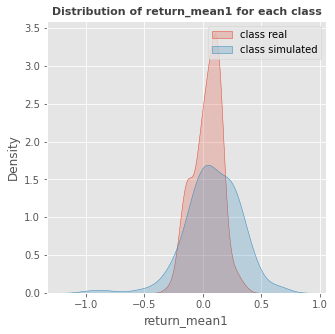

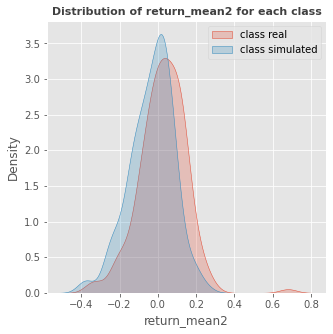

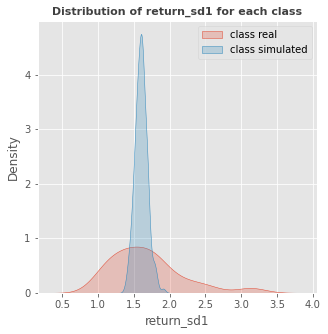

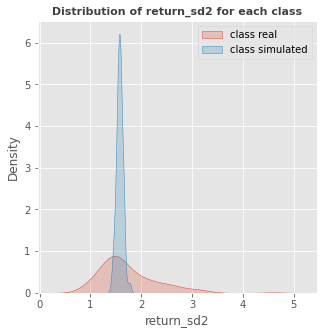

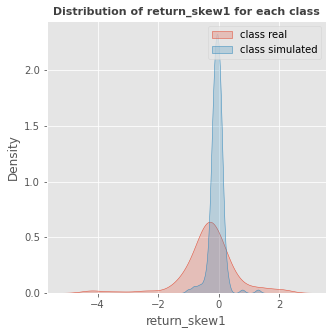

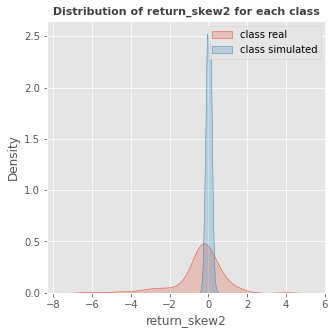

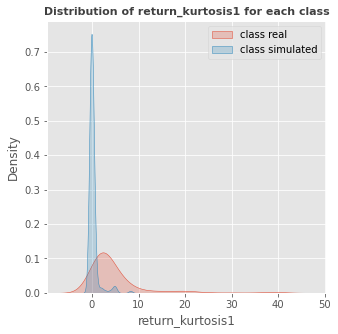

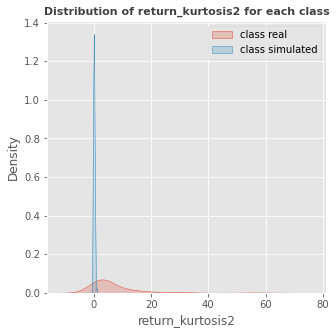

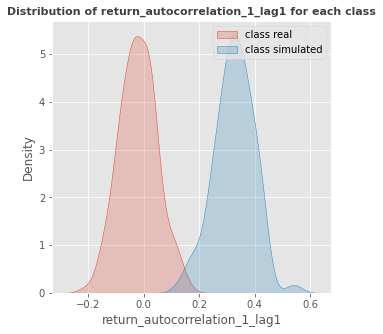

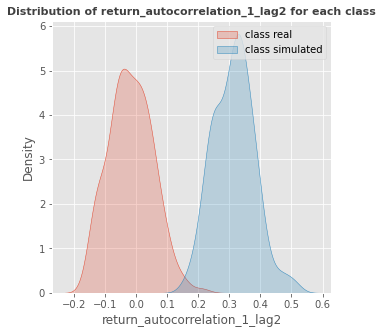

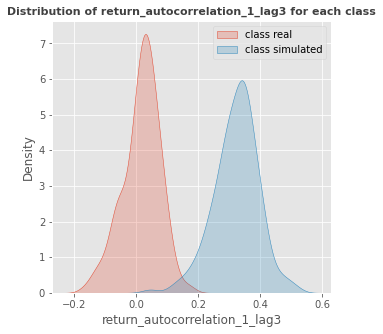

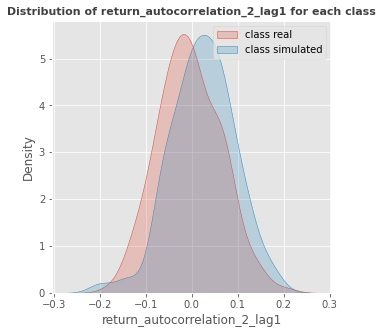

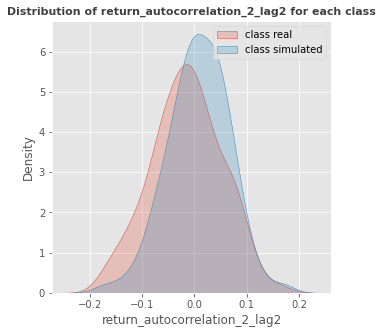

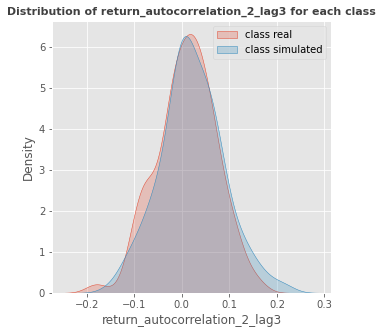

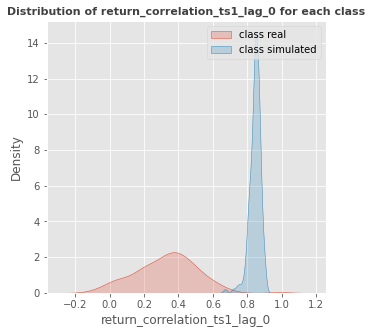

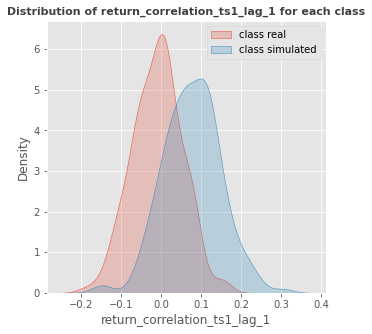

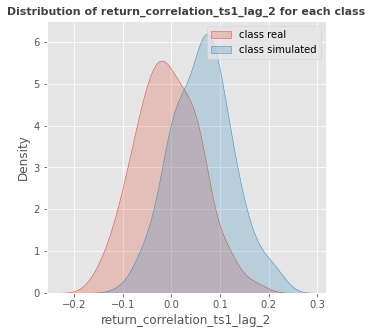

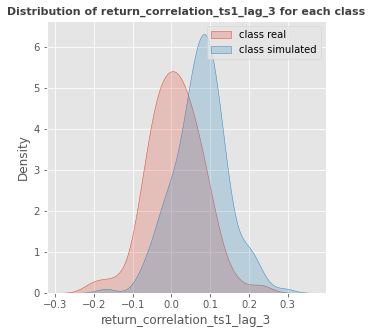

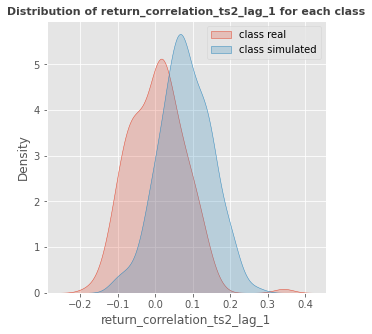

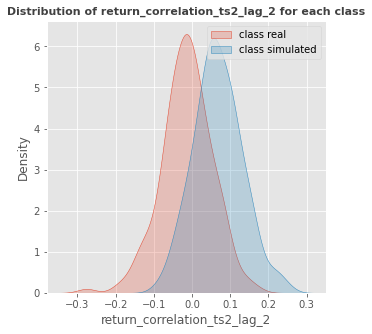

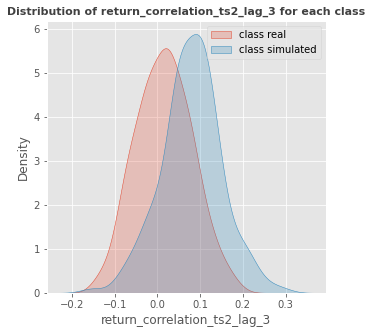

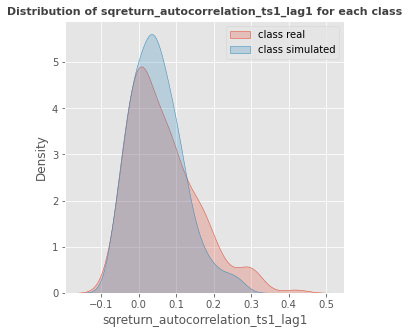

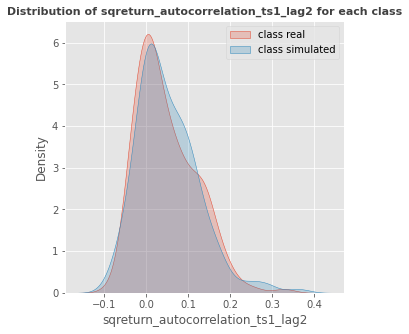

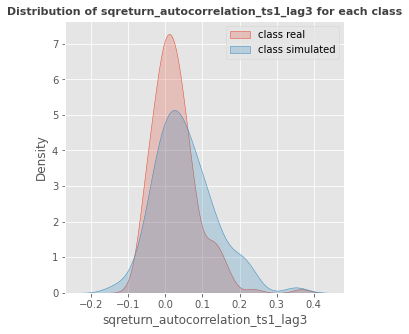

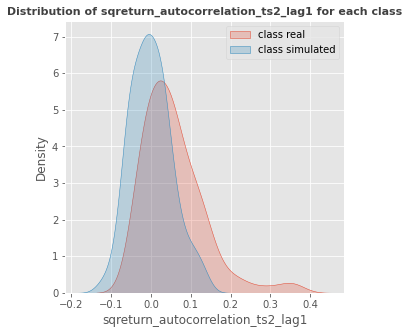

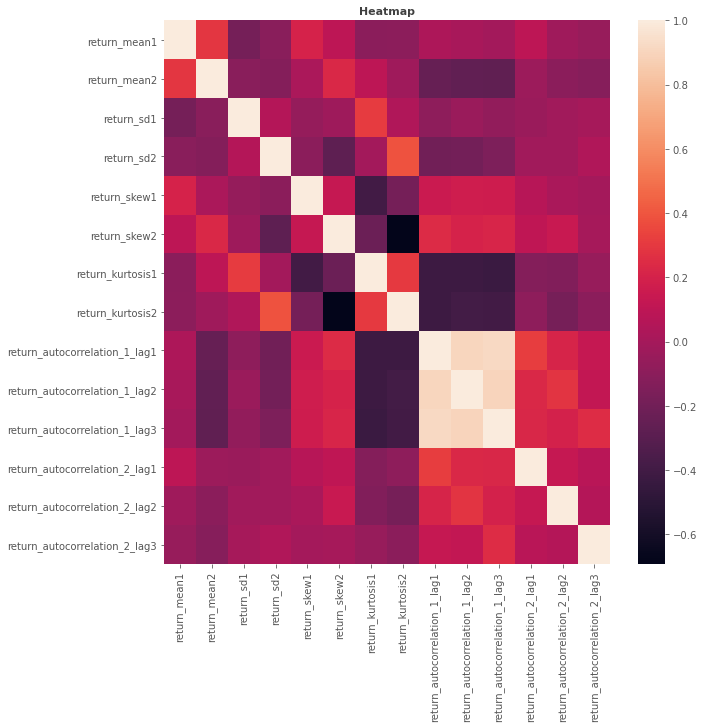

In [4]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_jumpou_log_prices = n_jumpou_simulation(
        random_seed=random_seed, num_sim=248,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=params[12], 
        beta1=beta1, beta2=beta2, 
        delta0=params[13], 
        mu1=params[14], mu2=params[15], 
        lambda11=params[16], lambda12=lambda12, 
        lambda21=lambda21, lambda22=1/params[16],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)

    n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
    n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

    n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")
    n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv")
    
    
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:36]
    y = dataset.iloc[:, 36]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)
EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_oujump")



In [5]:
print(results)
print(accuracy_average)
print(accuracy_std)

[1.0, 0.9865771812080537, 0.9865771812080537, 1.0, 1.0]
0.9946308724832214
0.006575811390021944
